In [4]:
import pandas as pd
import os
import numpy as np
import json

import seaborn as sns
sns.set_style("white")
from evalutils.roc import get_bootstrapped_roc_ci_curves
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from utilities import data
import copy

%matplotlib inline
import sklearn.metrics as skl_metrics
from IPython.display import display, Markdown

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
NLST_PREDS = f"{TEAMS_DIR}/nlst" ## Comment out if not using Teams backup (aka Chansey is up :)

## Get training data for each model

In [5]:
with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

kiran_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov4_allmodels_cal.csv")
kiran_data, nlst_democols_val, _ = data.prep_nlst_preds(kiran_nodule, nlst_democols, scanlevel=True, sybil=False, tijmen=False, bin_num=False)

nlst_democols_val['cat']['other'].append('label')
print(len(kiran_data), "Scans")
nlst_democols_val

10183 Scans


{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'other': ['NoduleCounts', 'Diameter_mm', 'SliceCount']},
 'cat': {'demo': ['Overweight',
   'educat',
   'Gender',
   'Married',
   'HighSchoolPlus',
   'NonHispanicWhite',
   'Unfinished_ed',
   'WhiteOrBlack',
   'marital',
   'ethnic',
   'race'],
  'smoke': ['smokelive', 'cigar', 'cigsmok', 'smokework', 'pipe'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'diaghype',
   'diagchro'],
  'canchist': ['canckidn',
   'cancphar',
   'canccolo',
   'cancoral',
   'cancpanc',
   'canccerv',
   'cancstom

In [6]:
nlst_democols_sybil = copy.deepcopy(nlst_democols_val)
nlst_democols_sybil['num'].pop('other')
nlst_democols_sybil['cat'].pop('nodule')
nlst_democols_sybil['cat']['other'].remove('label')
nlst_democols_sybil['cat'].pop('scanner')
nlst_democols_sybil

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr']},
 'cat': {'demo': ['Overweight',
   'educat',
   'Gender',
   'Married',
   'HighSchoolPlus',
   'NonHispanicWhite',
   'Unfinished_ed',
   'WhiteOrBlack',
   'marital',
   'ethnic',
   'race'],
  'smoke': ['smokelive', 'cigar', 'cigsmok', 'smokework', 'pipe'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'diaghype',
   'diagchro'],
  'canchist': ['canckidn',
   'cancphar',
   'canccolo',
   'cancoral',
   'cancpanc',
   'canccerv',
   'cancstom',
   'cancthyr',
   'canctran',
   'cancnasa',
   'cancla

In [7]:
cols_num = sum(nlst_democols_val['num'].values(), start=[])
cols_cat = sum(nlst_democols_val['cat'].values(), start=[])
cols_list_val = cols_num + cols_cat

In [8]:
cols_num = sum(nlst_democols_sybil['num'].values(), start=[])
cols_cat = sum(nlst_democols_sybil['cat'].values(), start=[])
cols_list_sybil = cols_num + cols_cat

Get data for Tijmen's linear layer.

In [9]:
tijmen_train = kiran_data[kiran_data['Thijmen_mean'].isna()]
print("train:", len(tijmen_train), "Scans")
tijmen_val = kiran_data[~kiran_data['Thijmen_mean'].isna()]
print("val:", len(tijmen_val), "Scans")

train: 8121 Scans
val: 2062 Scans


In [10]:
sybil_demos = pd.read_csv(f"{NLST_PREDS}/sybil-nlst-split-demov4.csv")
sybil_demos.nunique()

id                   41280
split                    3
pid                  14185
timepoint                3
SeriesInstanceUID    41280
                     ...  
cigsmok                  2
diagtube                 2
diagchro                 2
marital                  7
study                    3
Length: 86, dtype: int64

In [11]:
sybil_demos['WhiteOrBlack'] = sybil_demos['race'].replace([3, 4, 5, 6], value=np.nan, inplace=False)
sybil_demos['Overweight'] = (sybil_demos['BMI'] >= 25)
sybil_demos['Unfinished_ed'] = (sybil_demos['educat'] == 2) | (sybil_demos['educat'] == 5)

In [12]:
sybil_splits = {s: sybil_demos.query(f'split == "{s}"') for s in ['train', 'dev', 'test']}
print(len(sybil_splits['train']), 'Scans')

28160 Scans


## Do the models have different training demographics?

In [13]:
training_sets = {
    'Kiran': kiran_data,
    'Tijmen': tijmen_train,
    'Sybil': sybil_splits['train']
}

### Categorical columns

In [14]:
cat_demo_splits = data.combine_diff_dfs(nlst_democols_sybil['cat'], data.diffs_category_prevalence, training_sets)
display(cat_demo_splits.sort_values(by='diff_Kiran_Sybil', ascending=False).head(20))
cat_demo_splits.sort_values(by='diff_Kiran_Sybil', ascending=True).head(20)

,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Tijmen_Sybil
208,other,Emphysema,True,3697.0,36.3056,2942.0,36.2271,2317.0,8.2280,0.0785,28.0776,27.9991
210,lungcanc,LC_stage,110.0,596.0,5.8529,458.0,5.6397,549.0,1.9496,0.2132,3.9033,3.6901
202,other,FamilyHistoryLungCa,True,2622.0,25.7488,2110.0,25.9820,6232.0,22.1307,-0.2332,3.6181,3.8513
228,lungcanc,Adenocarcinoma,True,539.0,5.2931,410.0,5.0486,558.0,1.9815,0.2445,3.3116,3.0671
59,smoke,cigsmok,1,5088.0,49.9656,4028.0,49.5998,13386.0,47.5355,0.3658,2.4301,2.0643
0,demo,Overweight,False,3220.0,31.6213,2553.0,31.4370,8262.0,29.3395,0.1843,2.2818,2.0975
55,smoke,cigar,0.0,8215.0,80.6737,6544.0,80.5812,22137.0,78.6115,0.0925,2.0622,1.9697
121,disease,diagemph,1.0,1022.0,10.0363,817.0,10.0603,2317.0,8.2280,-0.0240,1.8083,1.8323
13,demo,Gender,2,4349.0,42.7084,3466.0,42.6795,11588.0,41.1506,0.0289,1.5578,1.5289
4,demo,educat,3.0,2538.0,24.9239,2001.0,24.6398,6581.0,23.3700,0.2841,1.5539,1.2698


,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Tijmen_Sybil
207,other,Emphysema,False,6486.0,63.6944,5179.0,63.7729,25788.0,91.5767,-0.0785,-27.8823,-27.8038
218,lungcanc,LC_stage,NaN,9011.0,88.4906,7210.0,88.7822,26725.0,94.9041,-0.2916,-6.4135,-6.1219
201,other,FamilyHistoryLungCa,False,7561.0,74.2512,6011.0,74.0180,21928.0,77.8693,0.2332,-3.6181,-3.8513
227,lungcanc,Adenocarcinoma,False,9644.0,94.7069,7711.0,94.9514,27602.0,98.0185,-0.2445,-3.3116,-3.0671
58,smoke,cigsmok,0,5095.0,50.0344,4093.0,50.4002,14774.0,52.4645,-0.3658,-2.4301,-2.0643
1,demo,Overweight,True,6963.0,68.3787,5568.0,68.5630,19898.0,70.6605,-0.1843,-2.2818,-2.0975
56,smoke,cigar,1.0,1934.0,18.9924,1550.0,19.0863,5942.0,21.1009,-0.0939,-2.1085,-2.0146
120,disease,diagemph,0.0,9136.0,89.7182,7283.0,89.6811,25788.0,91.5767,0.0371,-1.8585,-1.8956
7,demo,educat,6.0,1585.0,15.5652,1253.0,15.4291,4836.0,17.1733,0.1361,-1.6081,-1.7442
12,demo,Gender,1,5834.0,57.2916,4655.0,57.3205,16572.0,58.8494,-0.0289,-1.5578,-1.5289


In [15]:
display(cat_demo_splits.query('attribute == "LC_stage"').sort_values(by='diff_Kiran_Sybil', ascending=False).head(20))
cat_demo_splits.query('attribute == "LC_stage"').sort_values(by='diff_Kiran_Sybil', ascending=True).head(20)

,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Tijmen_Sybil
210,lungcanc,LC_stage,110.0,596.0,5.8529,458.0,5.6397,549.0,1.9496,0.2132,3.9033,3.6901
214,lungcanc,LC_stage,310.0,136.0,1.3356,99.0,1.2191,176.0,0.6250,0.1165,0.7106,0.5941
211,lungcanc,LC_stage,120.0,112.0,1.0999,95.0,1.1698,111.0,0.3942,-0.0699,0.7057,0.7756
212,lungcanc,LC_stage,210.0,84.0,0.8249,64.0,0.7881,98.0,0.3480,0.0368,0.4769,0.4401
216,lungcanc,LC_stage,400.0,169.0,1.6596,140.0,1.7239,384.0,1.3636,-0.0643,0.2960,0.3603
213,lungcanc,LC_stage,220.0,40.0,0.3928,27.0,0.3325,47.0,0.1669,0.0603,0.2259,0.1656
215,lungcanc,LC_stage,320.0,31.0,0.3044,24.0,0.2955,64.0,0.2273,0.0089,0.0771,0.0682
217,lungcanc,LC_stage,900.0,4.0,0.0393,4.0,0.0493,6.0,0.0213,-0.0100,0.0180,0.0280
218,lungcanc,LC_stage,NaN,9011.0,88.4906,7210.0,88.7822,26725.0,94.9041,-0.2916,-6.4135,-6.1219


,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Tijmen_Sybil
218,lungcanc,LC_stage,NaN,9011.0,88.4906,7210.0,88.7822,26725.0,94.9041,-0.2916,-6.4135,-6.1219
217,lungcanc,LC_stage,900.0,4.0,0.0393,4.0,0.0493,6.0,0.0213,-0.0100,0.0180,0.0280
215,lungcanc,LC_stage,320.0,31.0,0.3044,24.0,0.2955,64.0,0.2273,0.0089,0.0771,0.0682
213,lungcanc,LC_stage,220.0,40.0,0.3928,27.0,0.3325,47.0,0.1669,0.0603,0.2259,0.1656
216,lungcanc,LC_stage,400.0,169.0,1.6596,140.0,1.7239,384.0,1.3636,-0.0643,0.2960,0.3603
212,lungcanc,LC_stage,210.0,84.0,0.8249,64.0,0.7881,98.0,0.3480,0.0368,0.4769,0.4401
211,lungcanc,LC_stage,120.0,112.0,1.0999,95.0,1.1698,111.0,0.3942,-0.0699,0.7057,0.7756
214,lungcanc,LC_stage,310.0,136.0,1.3356,99.0,1.2191,176.0,0.6250,0.1165,0.7106,0.5941
210,lungcanc,LC_stage,110.0,596.0,5.8529,458.0,5.6397,549.0,1.9496,0.2132,3.9033,3.6901


In [16]:
display(cat_demo_splits.query('category == "demo"').sort_values(by='diff_Kiran_Sybil', ascending=False).head(20))
cat_demo_splits.query('category == "demo"').sort_values(by='diff_Kiran_Sybil', ascending=True).head(20)

,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Tijmen_Sybil
0,demo,Overweight,False,3220.0,31.6213,2553.0,31.4370,8262.0,29.3395,0.1843,2.2818,2.0975
13,demo,Gender,2,4349.0,42.7084,3466.0,42.6795,11588.0,41.1506,0.0289,1.5578,1.5289
4,demo,educat,3.0,2538.0,24.9239,2001.0,24.6398,6581.0,23.3700,0.2841,1.5539,1.2698
31,demo,marital,3.0,864.0,8.4847,659.0,8.1148,2055.0,7.2976,0.3699,1.1871,0.8172
14,demo,Married,False,3328.0,32.6819,2654.0,32.6807,8878.0,31.5270,0.0012,1.1549,1.1537
19,demo,NonHispanicWhite,True,9311.0,91.4367,7402.0,91.1464,25461.0,90.4155,0.2903,1.0212,0.7309
22,demo,WhiteOrBlack,1.0,9461.0,92.9098,7528.0,92.6979,25919.0,92.0419,0.2119,0.8679,0.6560
41,demo,race,1.0,9461.0,92.9098,7528.0,92.6979,25919.0,92.0419,0.2119,0.8679,0.6560
3,demo,educat,2.0,518.0,5.0869,401.0,4.9378,1265.0,4.4922,0.1491,0.5947,0.4456
20,demo,Unfinished_ed,False,7378.0,72.4541,5862.0,72.1832,20248.0,71.9034,0.2709,0.5507,0.2798


,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Tijmen_Sybil
1,demo,Overweight,True,6963.0,68.3787,5568.0,68.5630,19898.0,70.6605,-0.1843,-2.2818,-2.0975
7,demo,educat,6.0,1585.0,15.5652,1253.0,15.4291,4836.0,17.1733,0.1361,-1.6081,-1.7442
12,demo,Gender,1,5834.0,57.2916,4655.0,57.3205,16572.0,58.8494,-0.0289,-1.5578,-1.5289
15,demo,Married,True,6855.0,67.3181,5467.0,67.3193,19282.0,68.4730,-0.0012,-1.1549,-1.1537
30,demo,marital,2.0,6855.0,67.3181,5467.0,67.3193,19282.0,68.4730,-0.0012,-1.1549,-1.1537
6,demo,educat,5.0,2287.0,22.4590,1858.0,22.8790,6647.0,23.6044,-0.4200,-1.1454,-0.7254
18,demo,NonHispanicWhite,False,872.0,8.5633,719.0,8.8536,2699.0,9.5845,-0.2903,-1.0212,-0.7309
21,demo,Unfinished_ed,True,2805.0,27.5459,2259.0,27.8168,7912.0,28.0966,-0.2709,-0.5507,-0.2798
29,demo,marital,1.0,416.0,4.0852,338.0,4.1620,1274.0,4.5241,-0.0768,-0.4389,-0.3621
43,demo,race,3.0,169.0,1.6596,146.0,1.7978,575.0,2.0419,-0.1382,-0.3823,-0.2441


### Numerical columns

In [17]:
num_demo_splits = data.combine_diff_dfs(nlst_democols_sybil['num'], data.diffs_numerical_means, training_sets)
display(num_demo_splits.sort_values(by='diff_Kiran_Sybil', ascending=False).query('diff_Kiran_Sybil > 0'))
num_demo_splits.sort_values(by='diff_Kiran_Sybil', ascending=True).query('diff_Kiran_Sybil < 0')

,category,attribute,value,Kiran,Tijmen,Sybil,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Tijmen_Sybil
15,smoke,pkyr,mean,57.9729,57.9599,56.1487,0.0130,1.8242,1.8112
3,demo,Age,mean,63.2049,63.1751,61.6496,0.0298,1.5553,1.5255
13,smoke,smokeyr,mean,41.0055,40.9844,39.9523,0.0211,1.0532,1.0321
2,demo,Age,50%,62.0000,62.0000,61.0000,0.0000,1.0000,1.0000
12,smoke,smokeyr,50%,41.0000,41.0000,40.0000,0.0000,1.0000,1.0000
14,smoke,pkyr,50%,50.0000,50.0000,49.0000,0.0000,1.0000,1.0000
11,smoke,smokeday,mean,28.5740,28.5444,28.4474,0.0296,0.1266,0.0970
5,demo,height,mean,67.8867,67.8719,67.8808,0.0148,0.0059,-0.0089


,category,attribute,value,Kiran,Tijmen,Sybil,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Tijmen_Sybil
7,demo,weight,mean,181.8113,181.8669,183.4129,-0.0556,-1.6016,-1.5460
1,demo,BMI,mean,27.6277,27.6476,27.8681,-0.0199,-0.2404,-0.2205
0,demo,BMI,50%,27.0197,27.0546,27.2592,-0.0349,-0.2395,-0.2046
9,smoke,smokeage,mean,16.5991,16.5993,16.7199,-0.0002,-0.1208,-0.1206


### Demographic correlations in the training data

In [18]:
correlations = {m: training_sets[m][cols_list_sybil].corr(method='kendall').round(2) for m in training_sets}
correlations['diff_Kiran_Tijmen'] = correlations['Kiran'] - correlations['Tijmen']
correlations['diff_Kiran_Sybil'] = correlations['Kiran'] - correlations['Sybil']

### Kiran

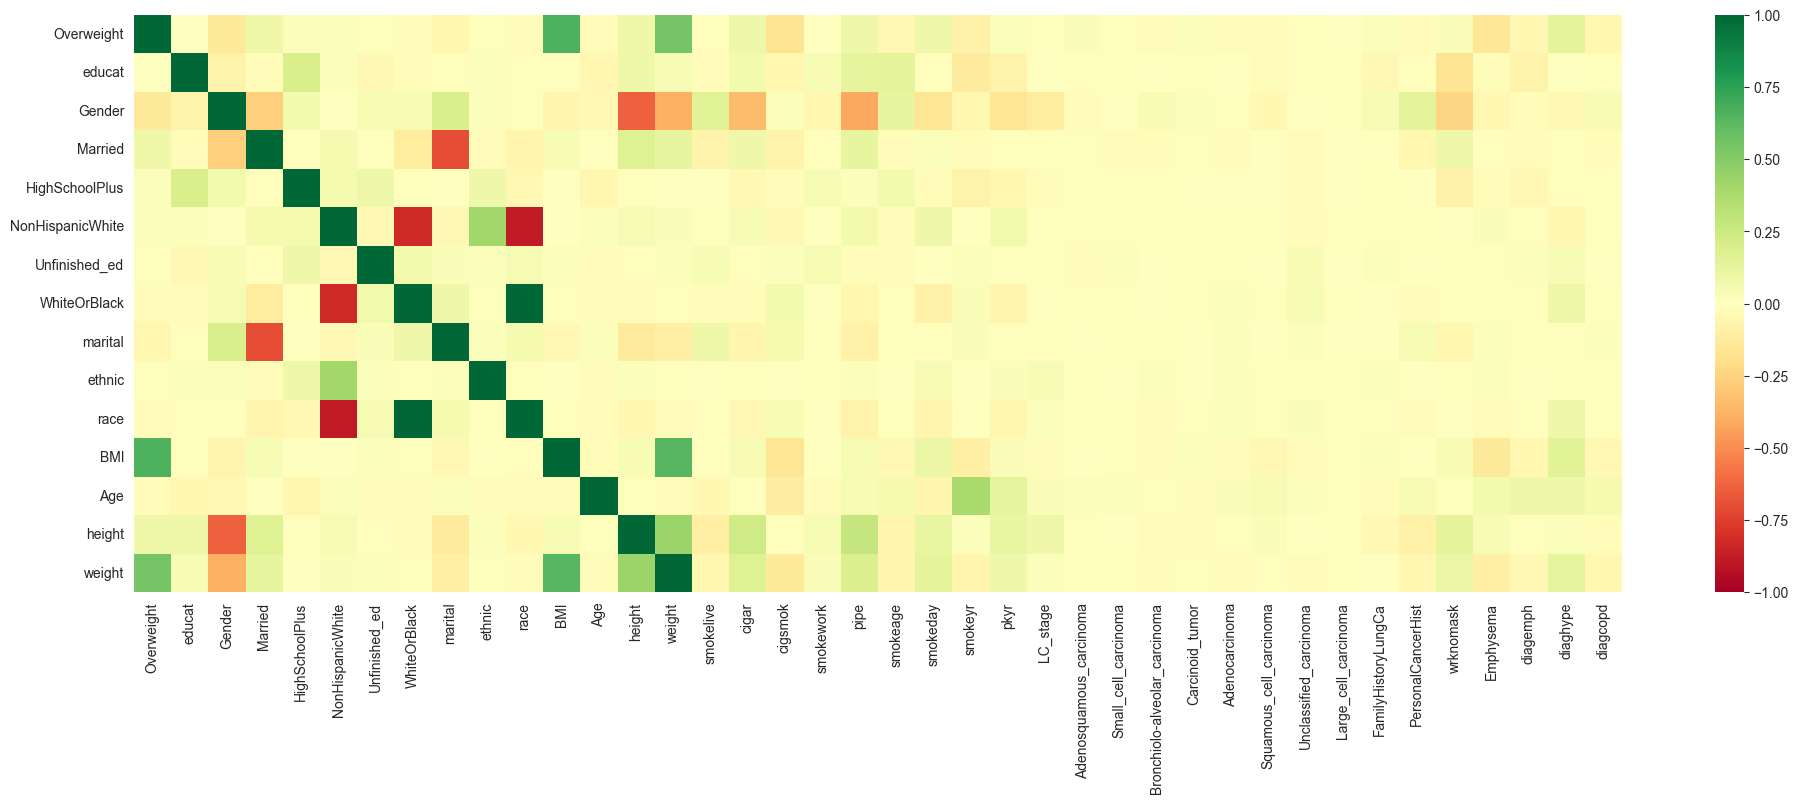

### Tijmen

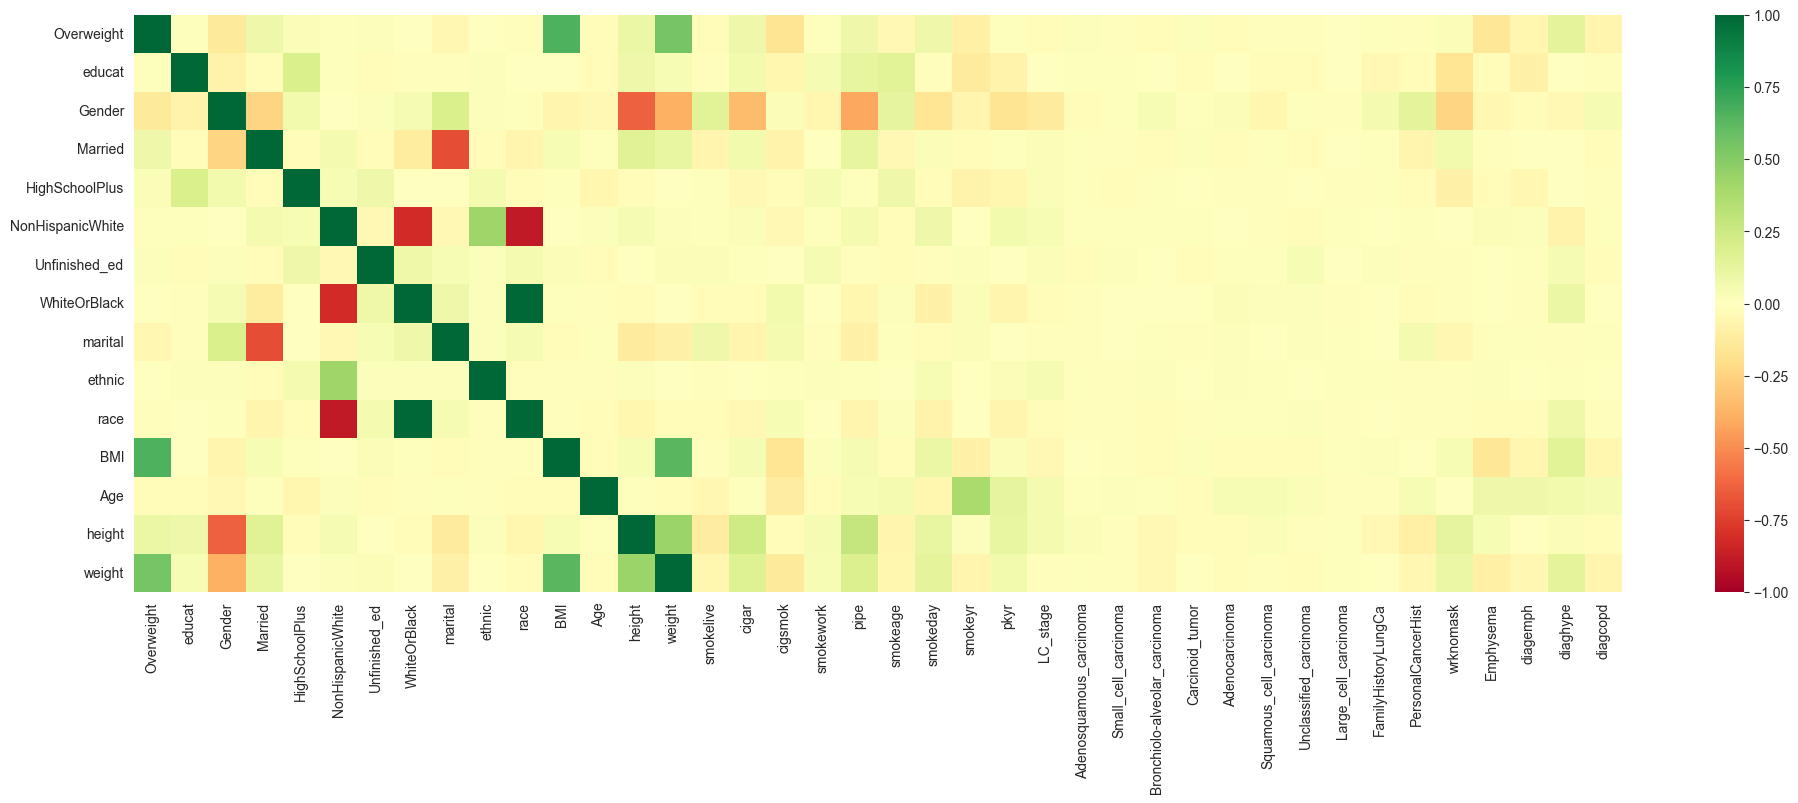

### Sybil

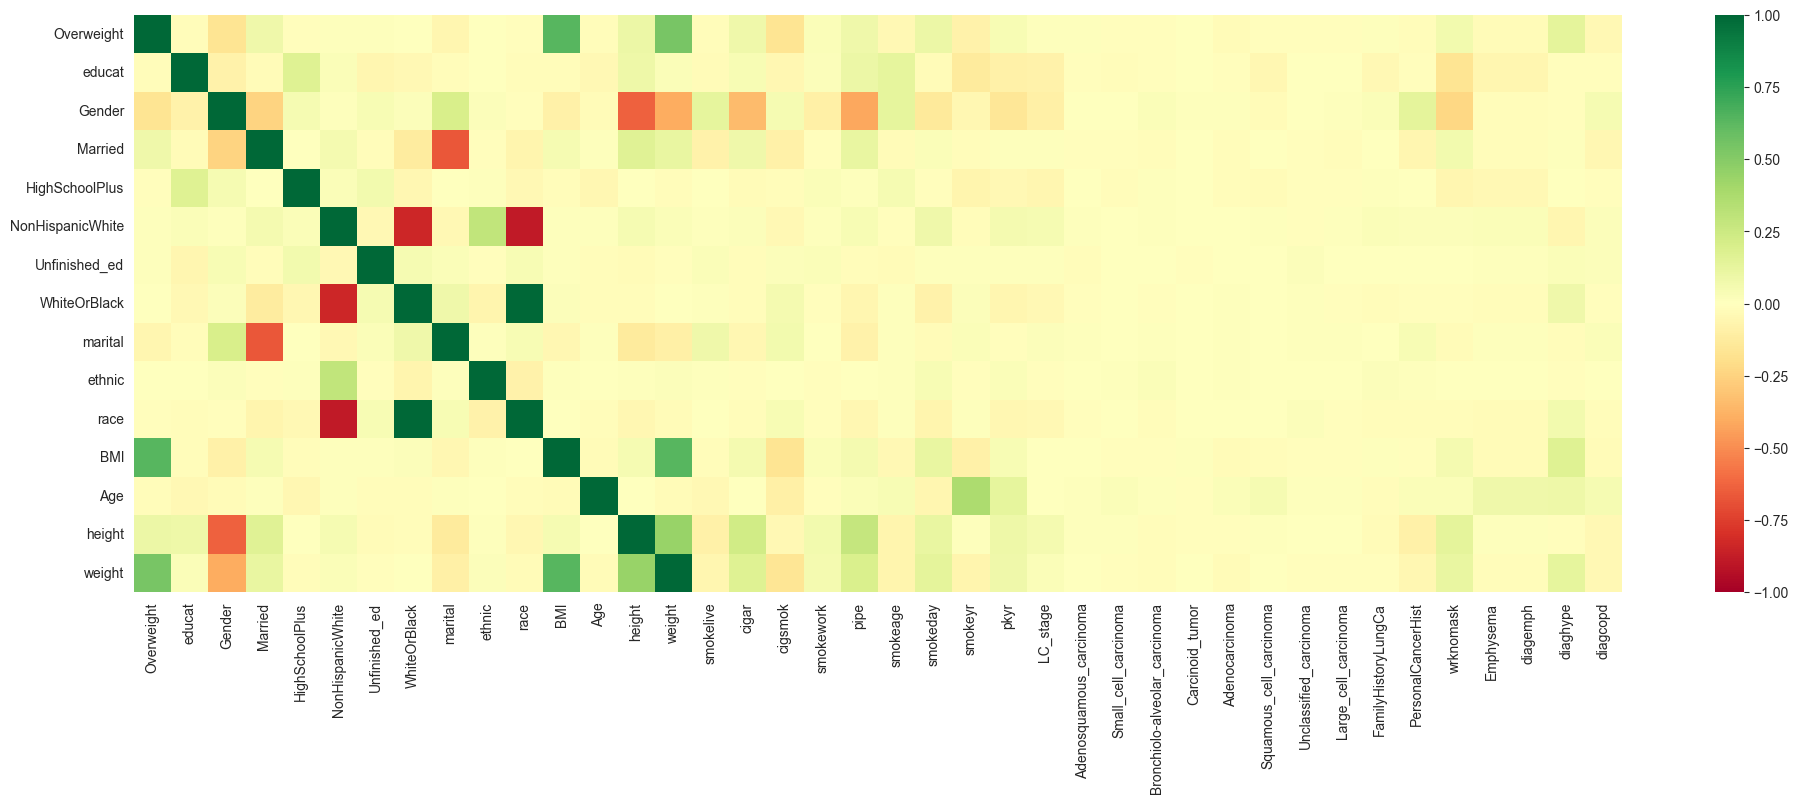

### diff_Kiran_Tijmen

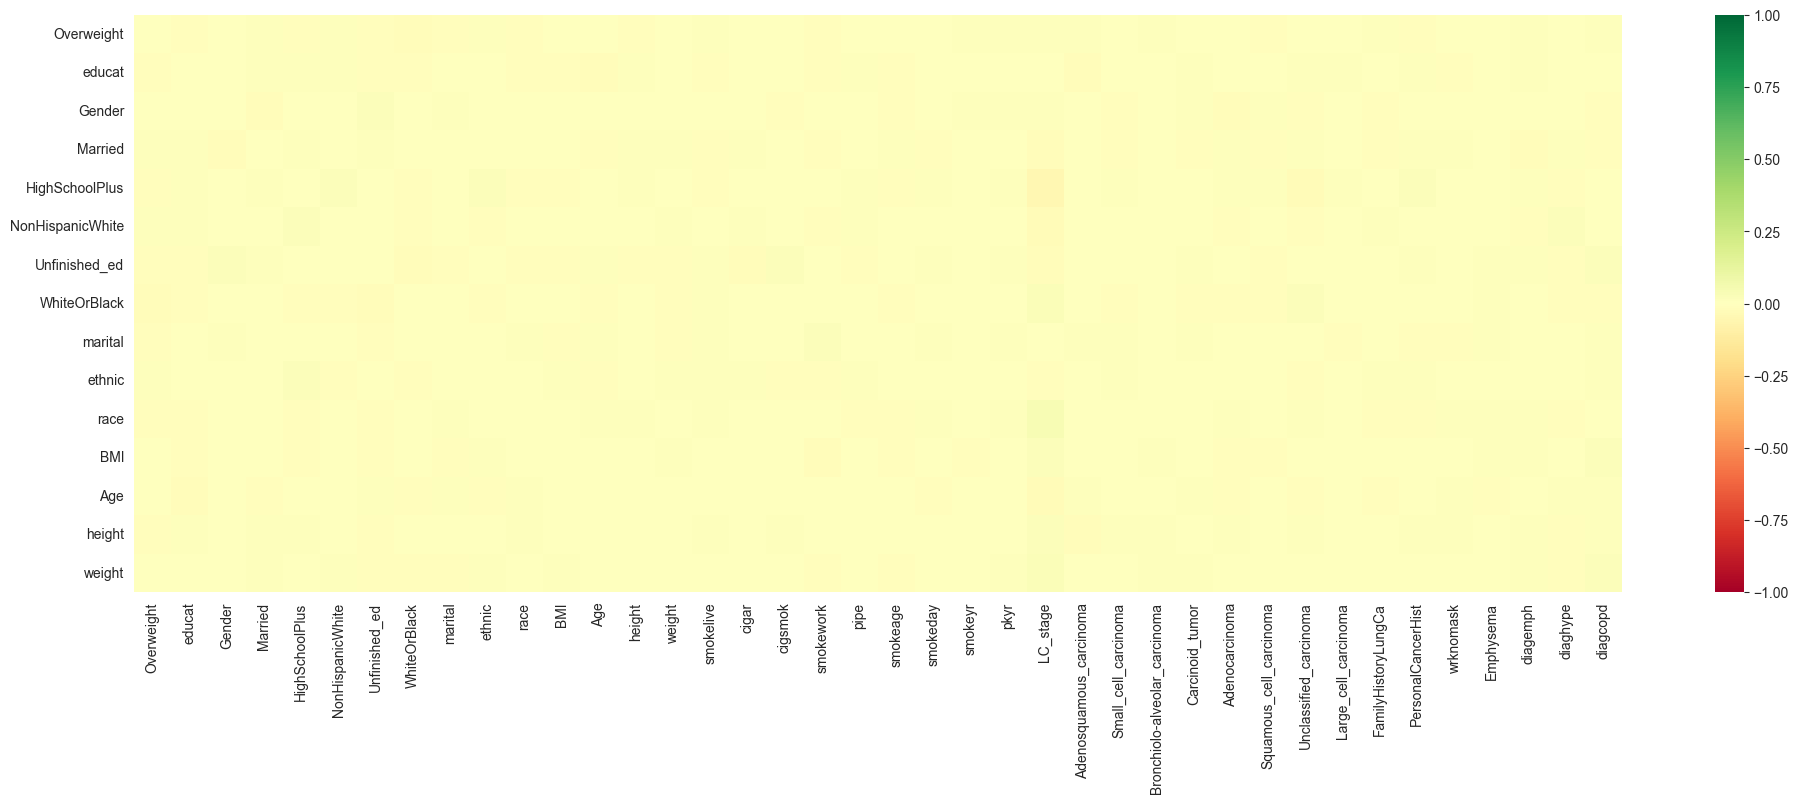

### diff_Kiran_Sybil

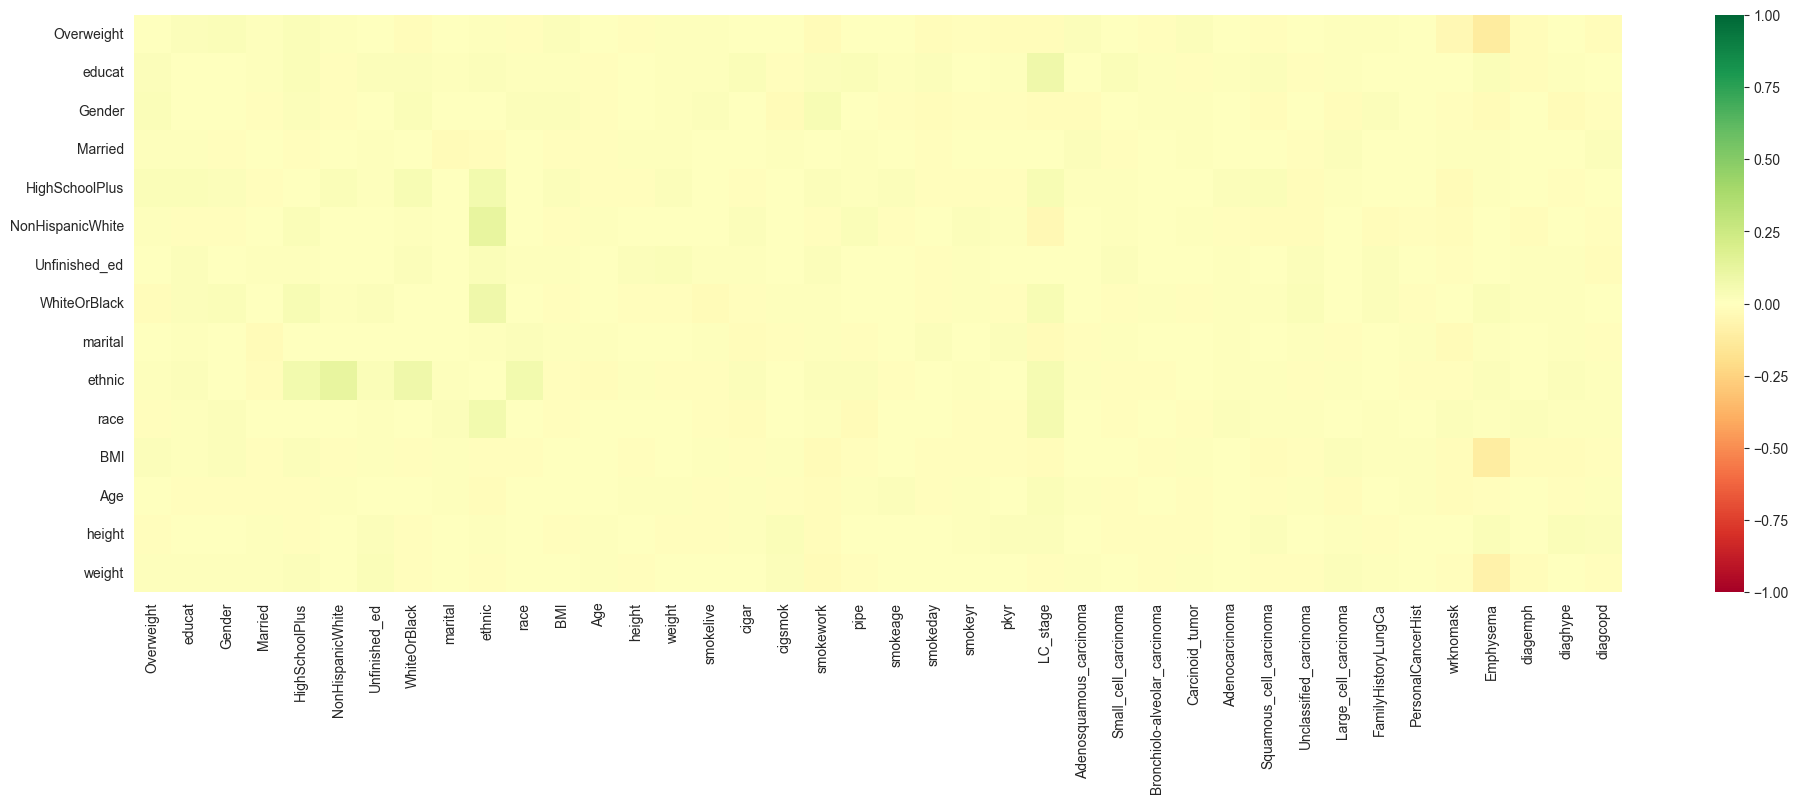

In [19]:
for m in correlations:
    corr_rows = nlst_democols['cat']['demo'] + nlst_democols['num']['demo']
    corr_cols = corr_rows + nlst_democols['cat']['smoke'] + nlst_democols['num']['smoke'] + nlst_democols['cat']['lungcanc'] + nlst_democols['cat']['other'] + ['diagemph', 'diaghype', 'diagcopd']
    # corr_cols, corr_rows = cols_list, cols_list
    
    display(Markdown(f"### {m}"))
    plt.figure(figsize=(len(corr_cols) * 0.6, len(corr_rows) * 0.5))
    sns.heatmap(correlations[m].loc[corr_rows, corr_cols], cmap='RdYlGn', vmin=-1, vmax=1)
    plt.show()

## Get demo splits (validation)

In [20]:
val_sets = {
    'Kiran': kiran_data,
    'Tijmen': tijmen_val,
    'Sybil': sybil_splits['dev'],
    'Sybil_test': sybil_splits['test']
}

### Categorical columns

In [21]:
cat_demo_val = data.combine_diff_dfs(nlst_democols_sybil['cat'], data.diffs_category_prevalence, val_sets)
display(cat_demo_val.sort_values(by='diff_Kiran_Sybil', ascending=False).head(20))
cat_demo_val.sort_values(by='diff_Kiran_Sybil', ascending=True).head(20)

,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,Sybil_test_freq,Sybil_test_norm,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Kiran_Sybil_test,diff_Tijmen_Sybil,diff_Tijmen_Sybil_test,diff_Sybil_Sybil_test
206,other,Emphysema,True,3697.0,36.3056,755.0,36.6149,576.0,8.4235,484.0,7.7046,-0.3093,27.8821,28.6010,28.1914,28.9103,0.7189
200,other,FamilyHistoryLungCa,True,2622.0,25.7488,512.0,24.8303,1469.0,21.4829,1362.0,21.6810,0.9185,4.2659,4.0678,3.3474,3.1493,-0.1981
226,lungcanc,Adenocarcinoma,True,539.0,5.2931,129.0,6.2561,82.0,1.1992,107.0,1.7033,-0.9630,4.0939,3.5898,5.0569,4.5528,-0.5041
208,lungcanc,LC_stage,110.0,596.0,5.8529,138.0,6.6925,127.0,1.8573,113.0,1.7988,-0.8396,3.9956,4.0541,4.8352,4.8937,0.0585
0,demo,Overweight,False,3220.0,31.6213,667.0,32.3472,1979.0,28.9412,1930.0,30.7227,-0.7259,2.6801,0.8986,3.4060,1.6245,-1.7815
19,demo,NonHispanicWhite,True,9311.0,91.4367,1909.0,92.5800,6076.0,88.8564,5718.0,91.0220,-1.1433,2.5803,0.4147,3.7236,1.5580,-2.1656
58,smoke,cigsmok,1,5088.0,49.9656,1060.0,51.4064,3241.0,47.3969,3026.0,48.1694,-1.4408,2.5687,1.7962,4.0095,3.2370,-0.7725
22,demo,WhiteOrBlack,1.0,9461.0,92.9098,1933.0,93.7439,6201.0,90.6844,5783.0,92.0567,-0.8341,2.2254,0.8531,3.0595,1.6872,-1.3723
41,demo,race,1.0,9461.0,92.9098,1933.0,93.7439,6201.0,90.6844,5783.0,92.0567,-0.8341,2.2254,0.8531,3.0595,1.6872,-1.3723
54,smoke,cigar,0.0,8215.0,80.6737,1671.0,81.0378,5376.0,78.6195,4889.0,77.8255,-0.3641,2.0542,2.8482,2.4183,3.2123,0.7940


,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,Sybil_test_freq,Sybil_test_norm,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Kiran_Sybil_test,diff_Tijmen_Sybil,diff_Tijmen_Sybil_test,diff_Sybil_Sybil_test
205,other,Emphysema,False,6486.0,63.6944,1307.0,63.3851,6256.0,91.4887,5783.0,92.0567,0.3093,-27.7943,-28.3623,-28.1036,-28.6716,-0.5680
216,lungcanc,LC_stage,NaN,9011.0,88.4906,1801.0,87.3424,6506.0,95.1448,5979.0,95.1767,1.1482,-6.6542,-6.6861,-7.8024,-7.8343,-0.0319
199,other,FamilyHistoryLungCa,False,7561.0,74.2512,1550.0,75.1697,5369.0,78.5171,4920.0,78.3190,-0.9185,-4.2659,-4.0678,-3.3474,-3.1493,0.1981
225,lungcanc,Adenocarcinoma,False,9644.0,94.7069,1933.0,93.7439,6756.0,98.8008,6175.0,98.2967,0.9630,-4.0939,-3.5898,-5.0569,-4.5528,0.5041
1,demo,Overweight,True,6963.0,68.3787,1395.0,67.6528,4859.0,71.0588,4352.0,69.2773,0.7259,-2.6801,-0.8986,-3.4060,-1.6245,1.7815
18,demo,NonHispanicWhite,False,872.0,8.5633,153.0,7.4200,762.0,11.1436,564.0,8.9780,1.1433,-2.5803,-0.4147,-3.7236,-1.5580,2.1656
57,smoke,cigsmok,0,5095.0,50.0344,1002.0,48.5936,3597.0,52.6031,3256.0,51.8306,1.4408,-2.5687,-1.7962,-4.0095,-3.2370,0.7725
55,smoke,cigar,1.0,1934.0,18.9924,384.0,18.6227,1450.0,21.2050,1376.0,21.9039,0.3697,-2.2126,-2.9115,-2.5823,-3.2812,-0.6989
119,disease,diagemph,0.0,9136.0,89.7182,1853.0,89.8642,6256.0,91.4887,5783.0,92.0567,-0.1460,-1.7705,-2.3385,-1.6245,-2.1925,-0.5680
140,disease,diagcopd,0.0,9479.0,93.0865,1916.0,92.9195,6478.0,94.7353,5930.0,94.3967,0.1670,-1.6488,-1.3102,-1.8158,-1.4772,0.3386


### Numerical columns

In [22]:
num_demo_val = data.combine_diff_dfs(nlst_democols_sybil['num'], data.diffs_numerical_means, val_sets)    

In [23]:
display(num_demo_val.sort_values(by='diff_Kiran_Sybil', ascending=False).head(20))
num_demo_val.sort_values(by='diff_Kiran_Sybil', ascending=True).head(20)

,category,attribute,value,Kiran,Tijmen,Sybil,Sybil_test,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Kiran_Sybil_test,diff_Tijmen_Sybil,diff_Tijmen_Sybil_test,diff_Sybil_Sybil_test
14,smoke,pkyr,50%,50.0000,51.0000,48.0000,49.5000,-1.0000,2.0000,0.5000,3.0000,1.5000,-1.5000
3,demo,Age,mean,63.2049,63.3225,61.6000,61.5807,-0.1176,1.6049,1.6242,1.7225,1.7418,0.0193
15,smoke,pkyr,mean,57.9729,58.0242,56.4101,57.2229,-0.0513,1.5628,0.7500,1.6141,0.8013,-0.8128
13,smoke,smokeyr,mean,41.0055,41.0887,39.8867,40.1227,-0.0832,1.1188,0.8828,1.2020,0.9660,-0.2360
12,smoke,smokeyr,50%,41.0000,41.0000,40.0000,40.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000
2,demo,Age,50%,62.0000,63.0000,61.0000,61.0000,-1.0000,1.0000,1.0000,2.0000,2.0000,0.0000
5,demo,height,mean,67.8867,67.9452,67.8172,67.9108,-0.0585,0.0695,-0.0241,0.1280,0.0344,-0.0936
11,smoke,smokeday,mean,28.5740,28.6906,28.5390,28.9032,-0.1166,0.0350,-0.3292,0.1516,-0.2126,-0.3642
4,demo,height,50%,68.0000,68.0000,68.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,smoke,smokeage,50%,16.0000,16.0000,16.0000,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


,category,attribute,value,Kiran,Tijmen,Sybil,Sybil_test,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Kiran_Sybil_test,diff_Tijmen_Sybil,diff_Tijmen_Sybil_test,diff_Sybil_Sybil_test
7,demo,weight,mean,181.8113,181.5927,183.6606,183.6864,0.2186,-1.8493,-1.8751,-2.0679,-2.0937,-0.0258
1,demo,BMI,mean,27.6277,27.5492,27.9667,27.8674,0.0785,-0.3390,-0.2397,-0.4175,-0.3182,0.0993
0,demo,BMI,50%,27.0197,26.9151,27.3167,27.0927,0.1046,-0.2970,-0.0730,-0.4016,-0.1776,0.2240
9,smoke,smokeage,mean,16.5991,16.5984,16.7151,16.6479,0.0007,-0.1160,-0.0488,-0.1167,-0.0495,0.0672
6,demo,weight,50%,180.0000,178.0000,180.0000,180.0000,2.0000,0.0000,0.0000,-2.0000,-2.0000,0.0000
10,smoke,smokeday,50%,25.0000,25.0000,25.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,smoke,smokeage,50%,16.0000,16.0000,16.0000,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,demo,height,50%,68.0000,68.0000,68.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
11,smoke,smokeday,mean,28.5740,28.6906,28.5390,28.9032,-0.1166,0.0350,-0.3292,0.1516,-0.2126,-0.3642
5,demo,height,mean,67.8867,67.9452,67.8172,67.9108,-0.0585,0.0695,-0.0241,0.1280,0.0344,-0.0936


### Demographic correlations

In [24]:
correlations = {m: val_sets[m][cols_list_sybil].corr(method='kendall').round(2) for m in val_sets}
corr0 = correlations.copy()    
for i, m1 in enumerate(corr0):
    for j, m2 in enumerate(corr0):
        if j > i:
            correlations[f"diff_{m1}_{m2}"] = correlations[f"{m1}"] - correlations[f"{m2}"]

### Kiran

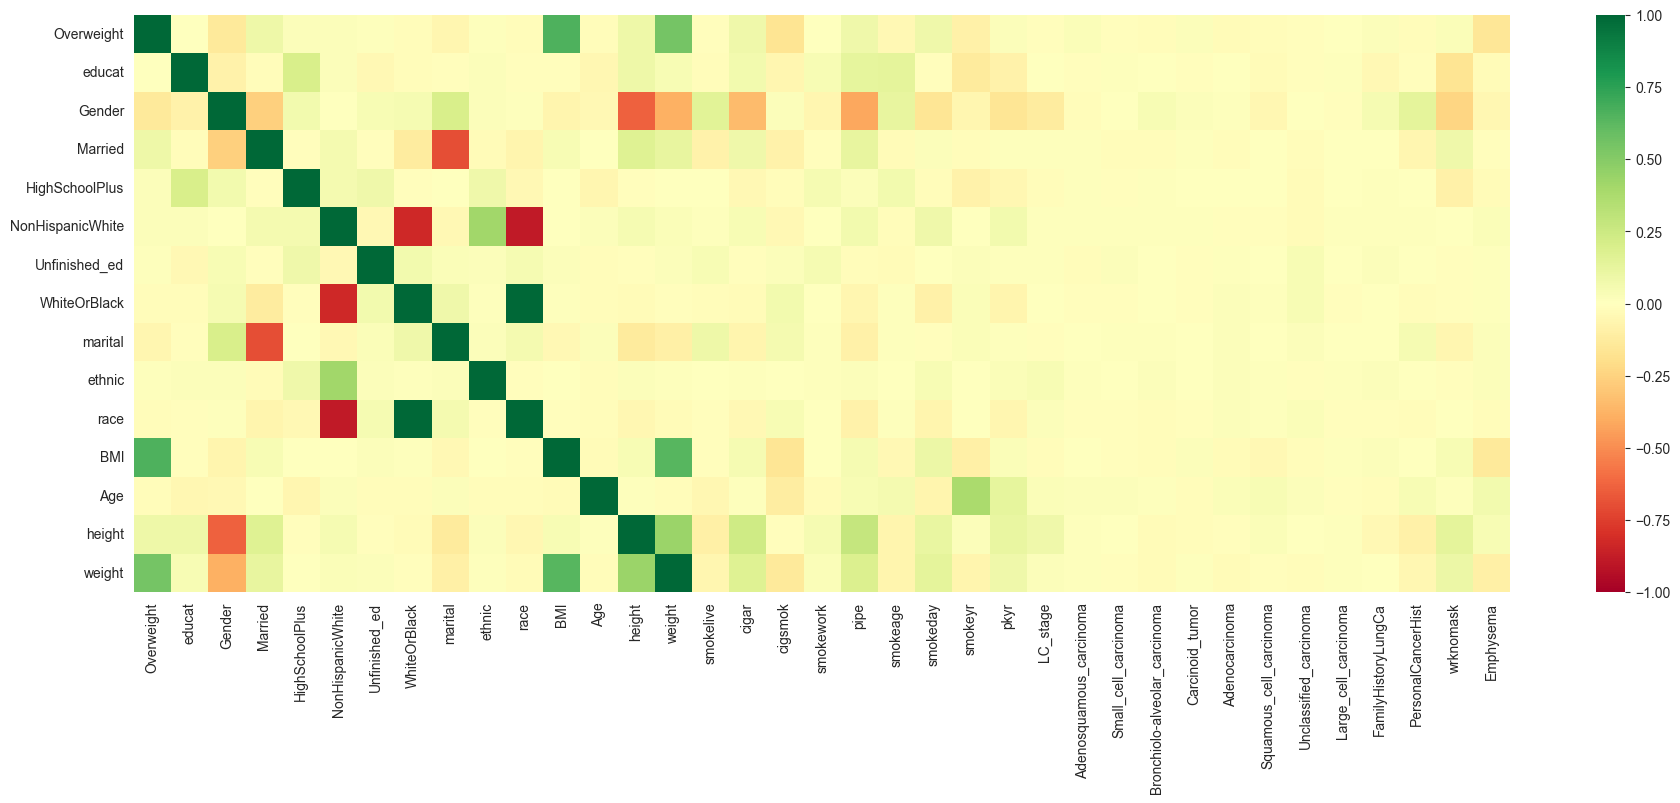

### Tijmen

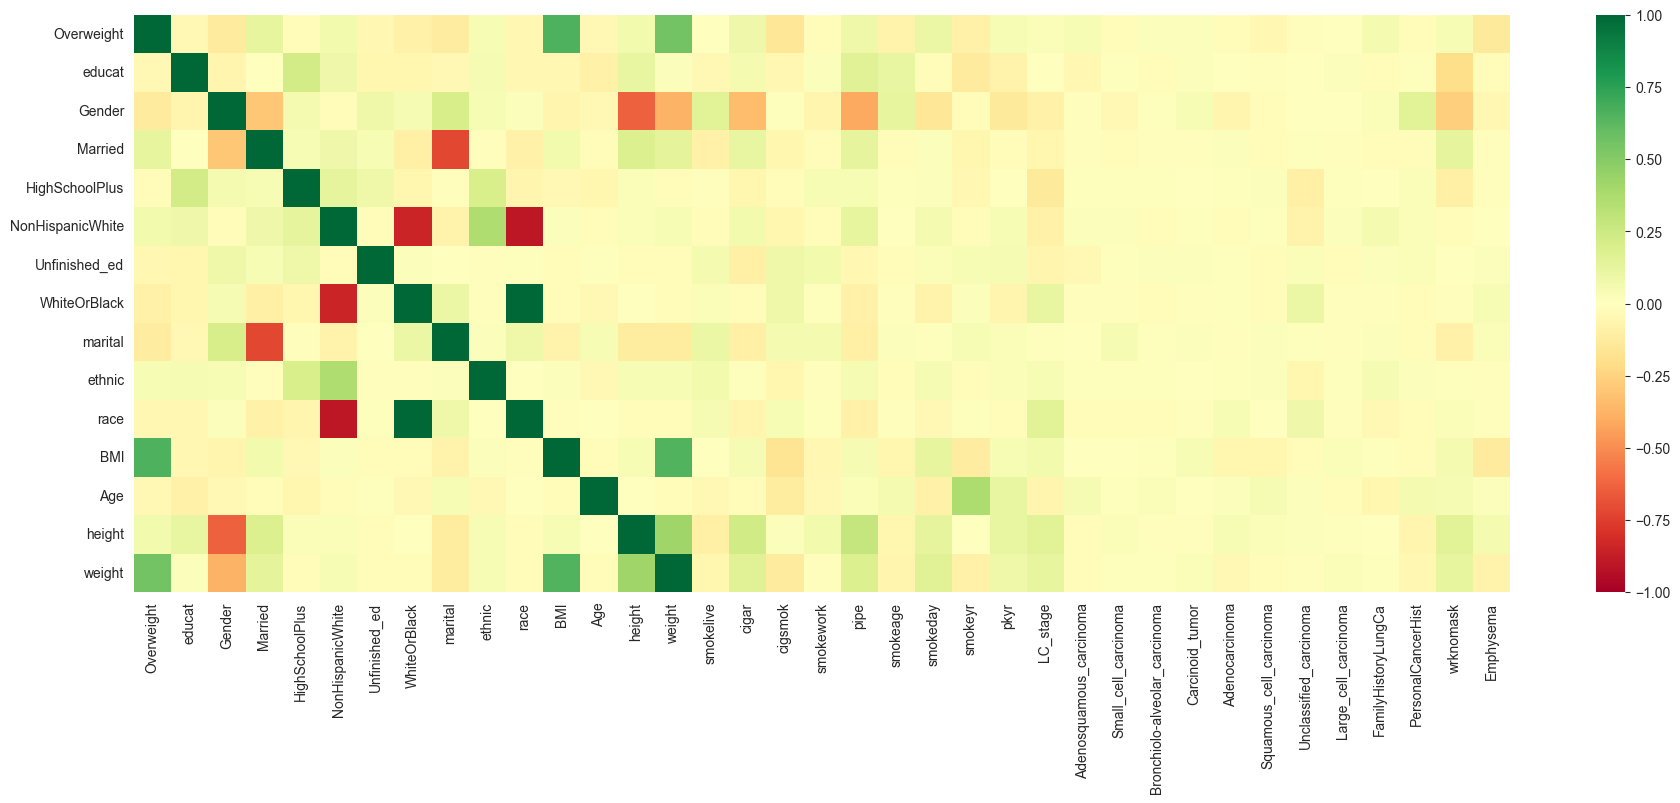

### Sybil

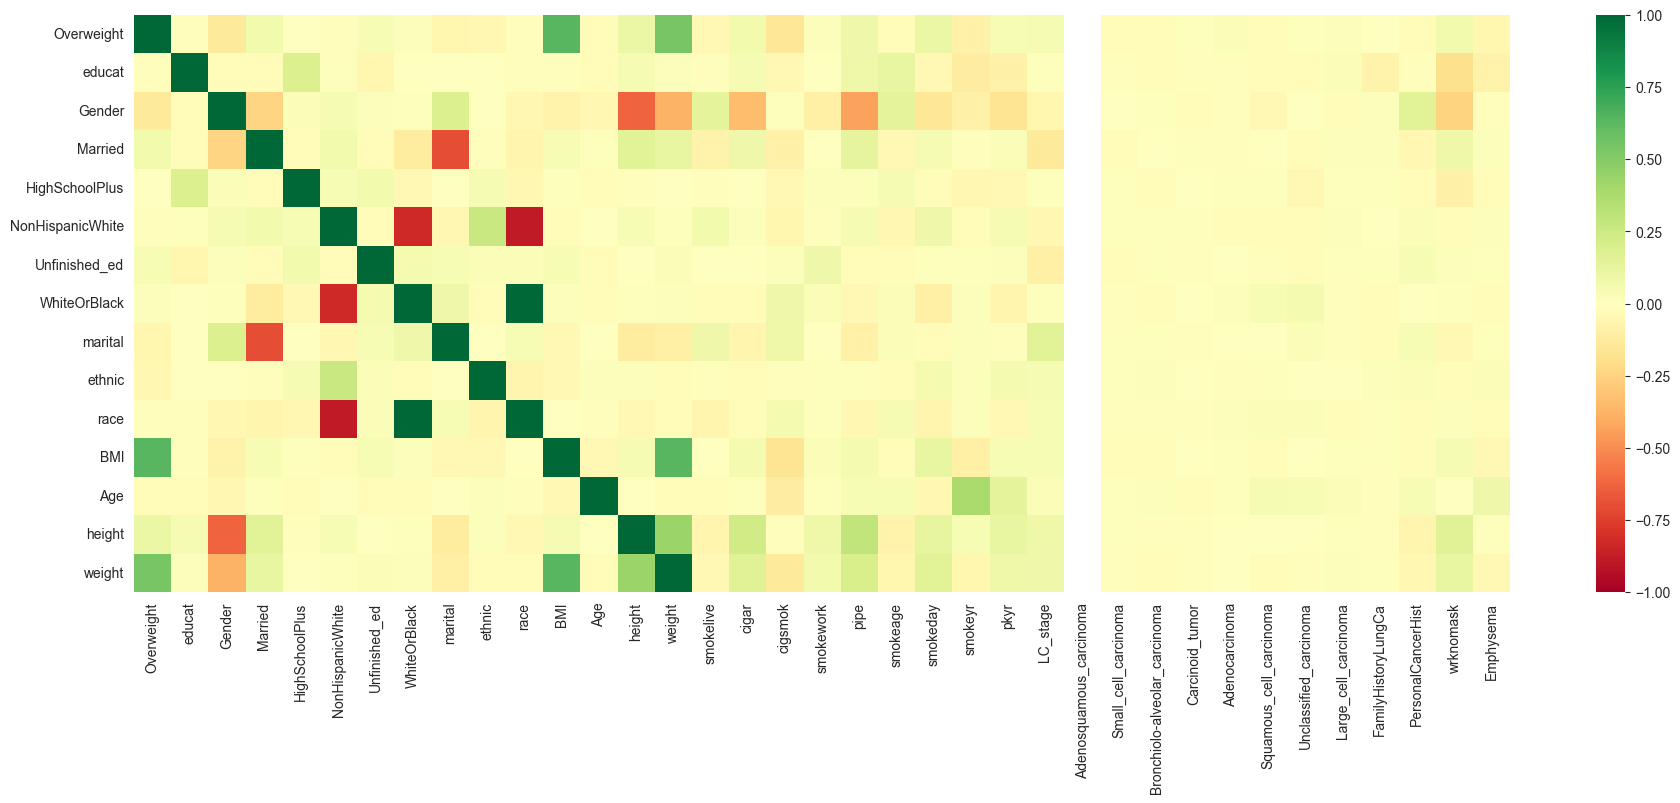

### Sybil_test

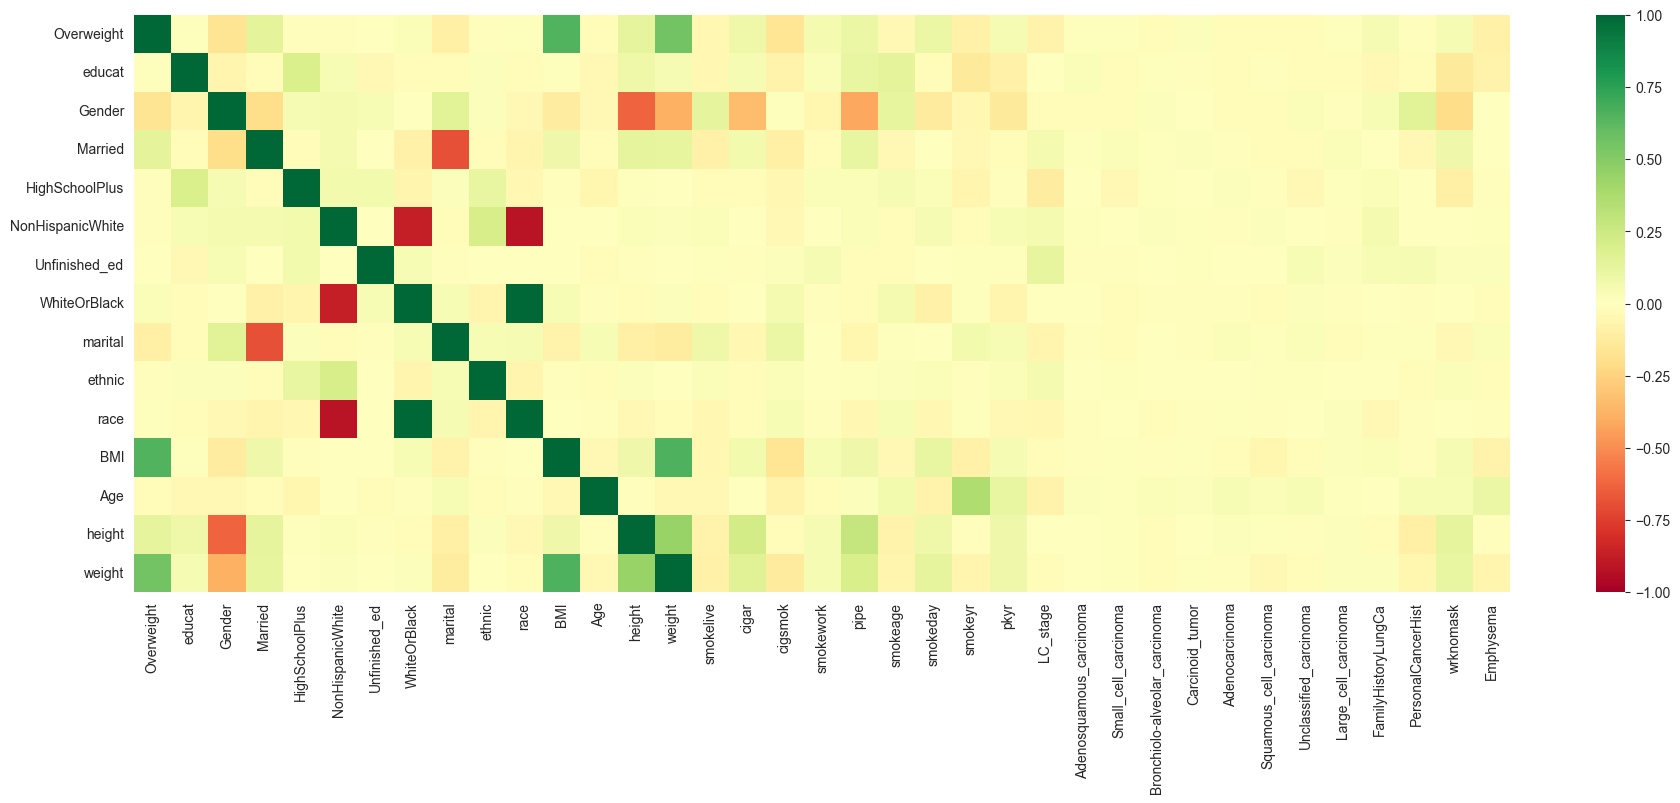

### diff_Kiran_Tijmen

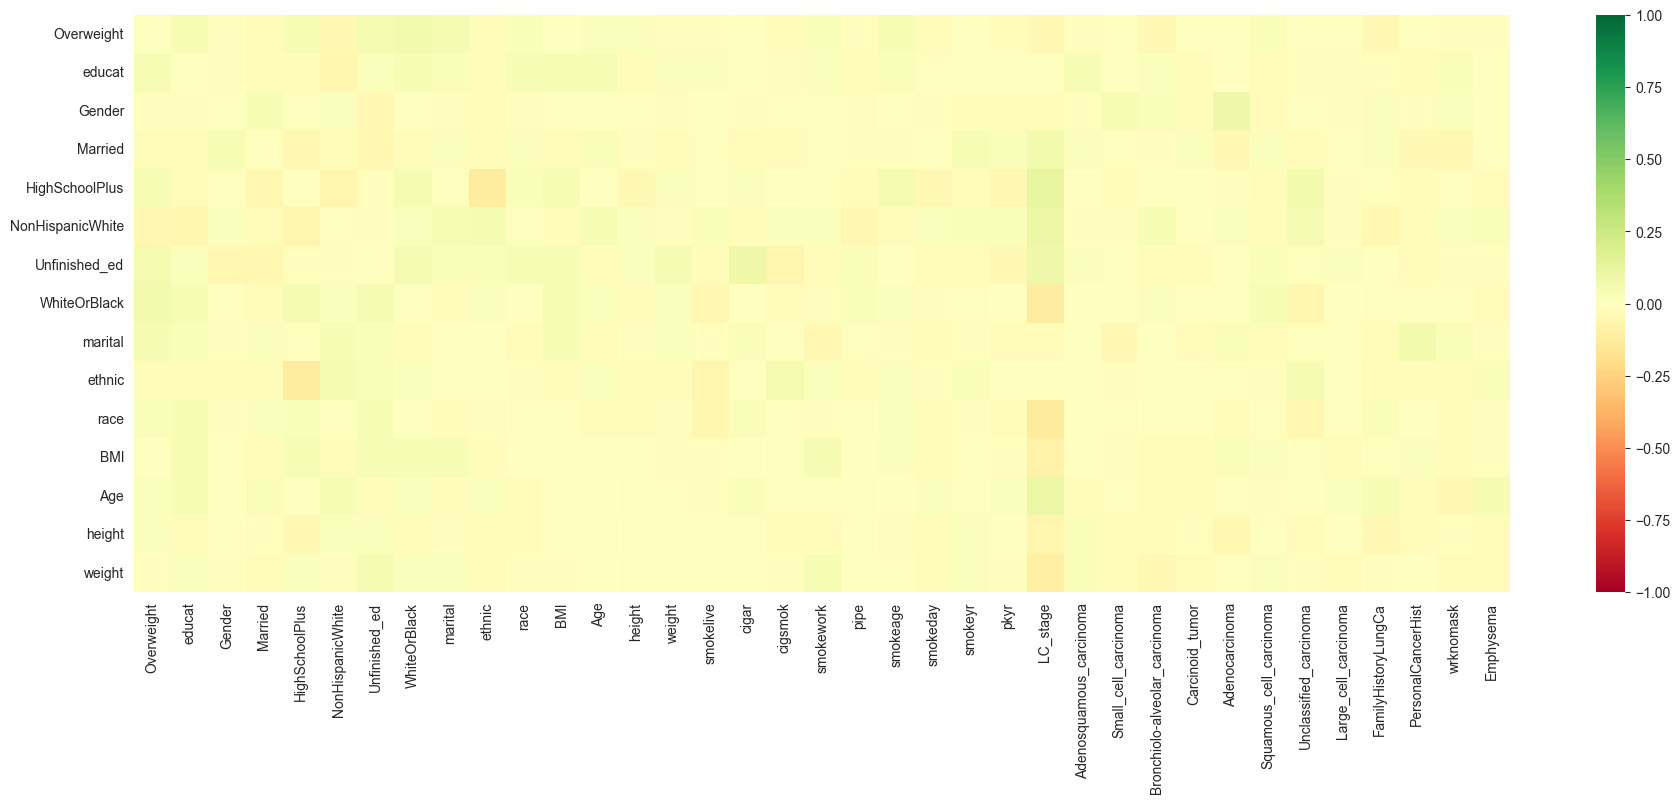

### diff_Kiran_Sybil

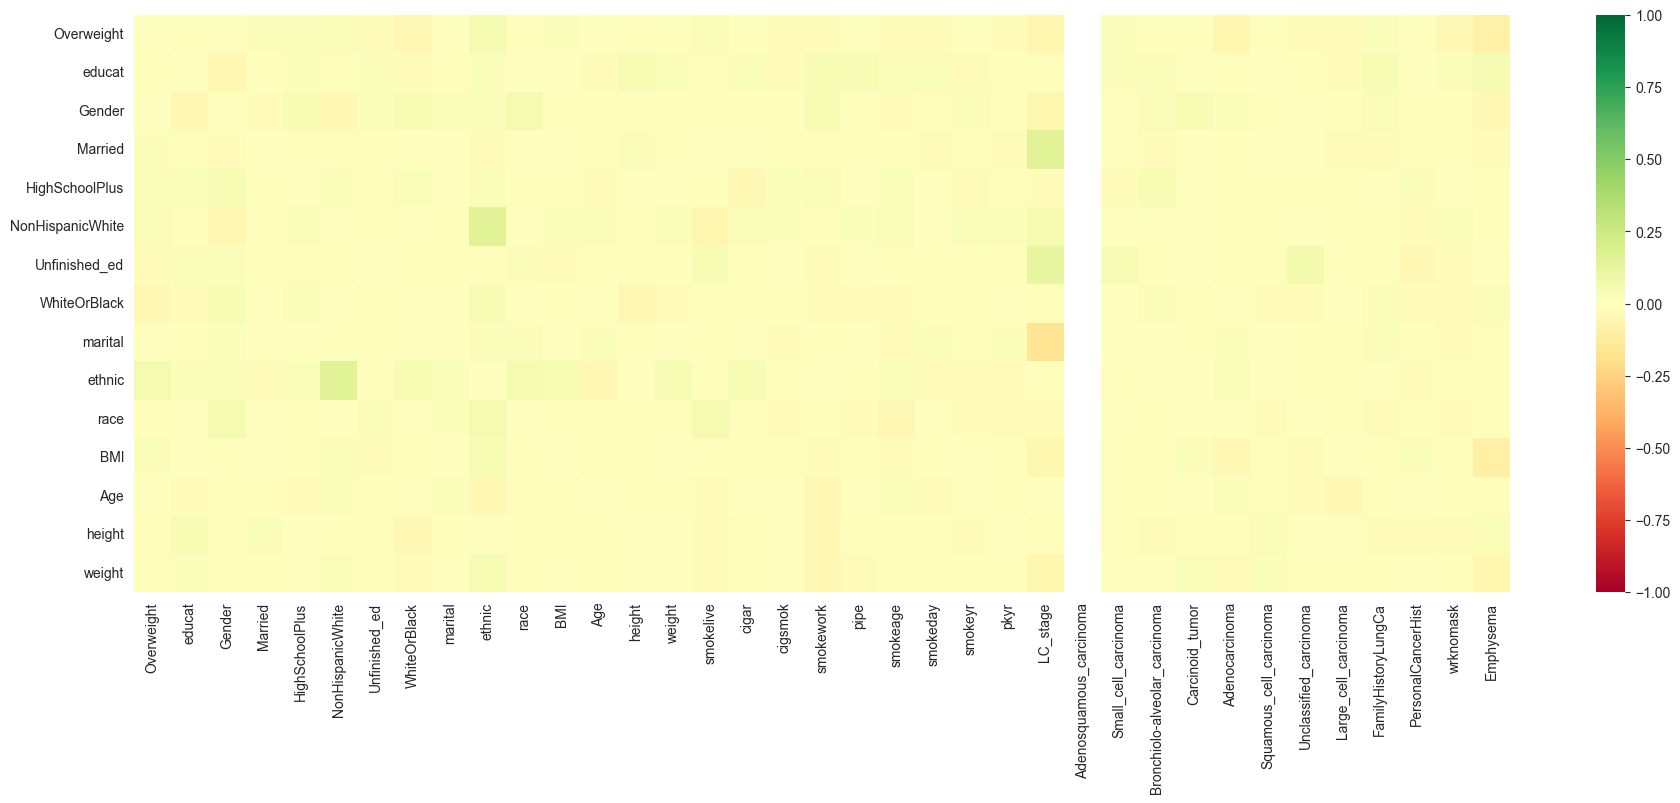

### diff_Kiran_Sybil_test

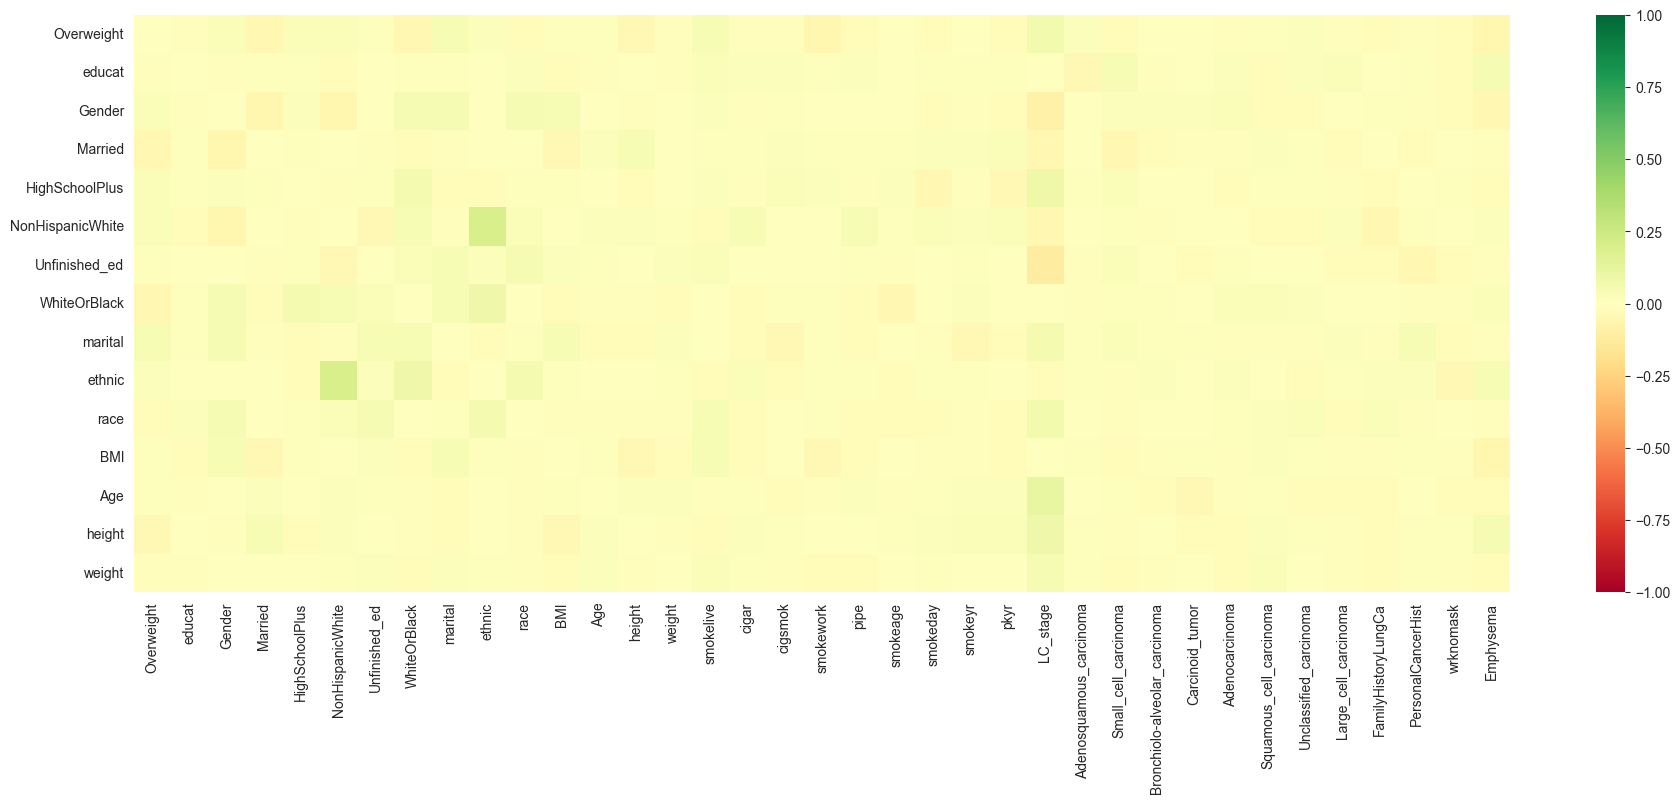

### diff_Tijmen_Sybil

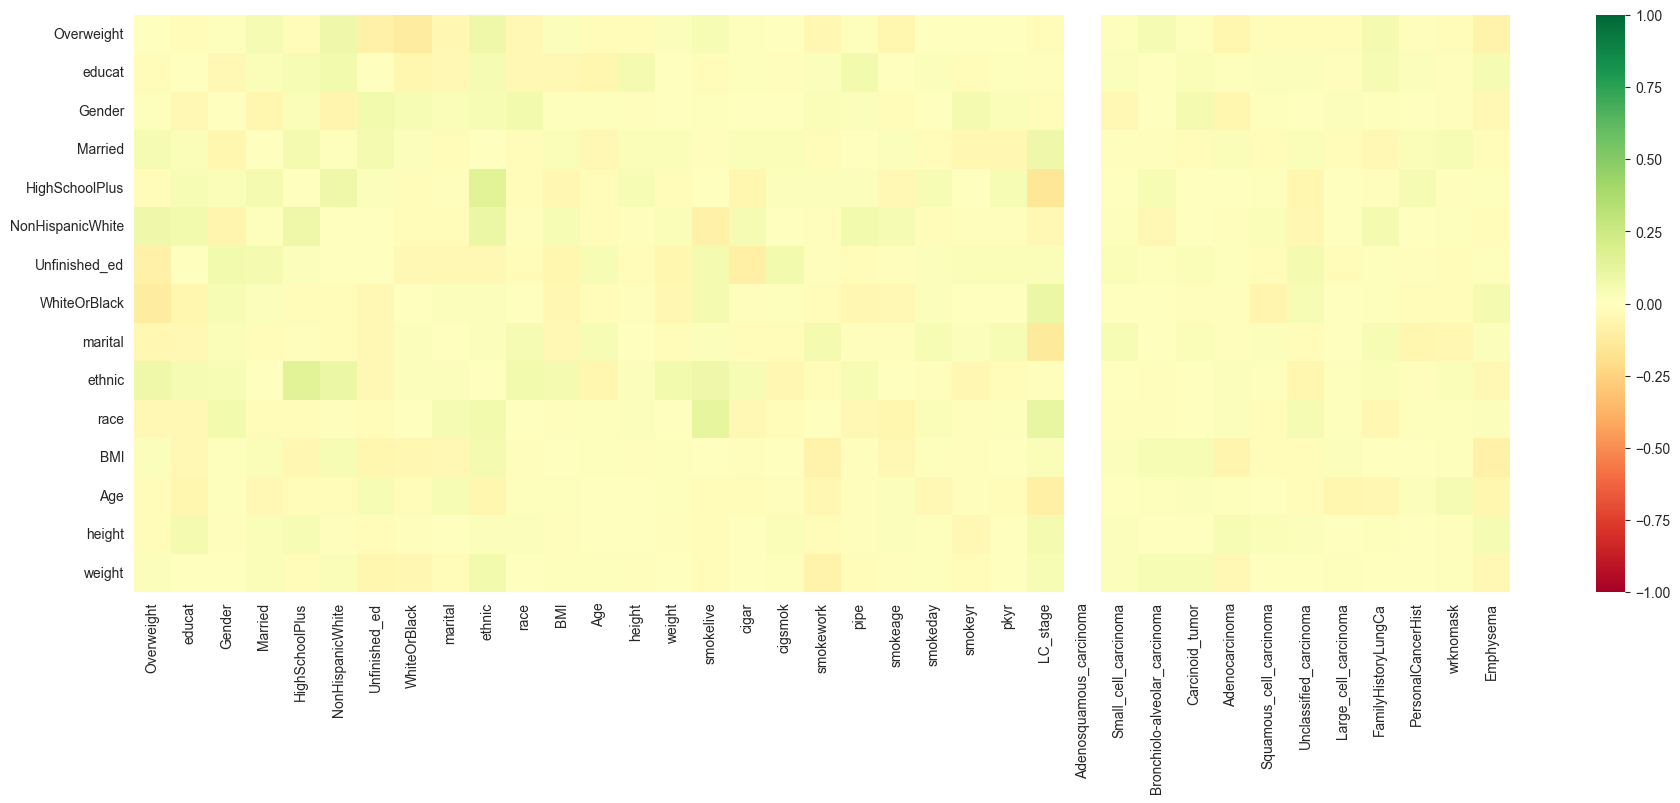

### diff_Tijmen_Sybil_test

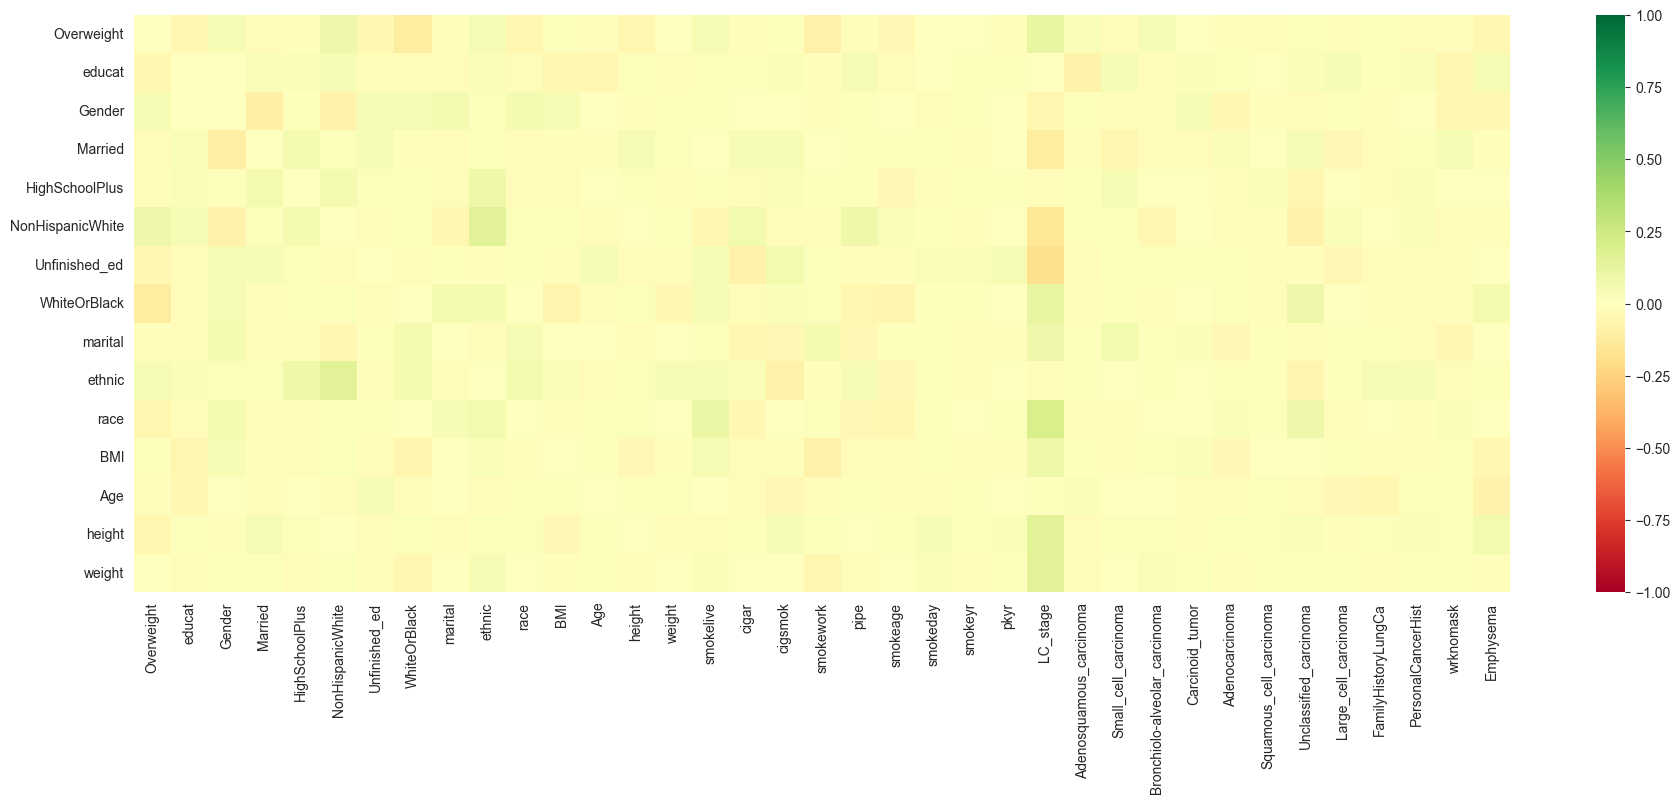

### diff_Sybil_Sybil_test

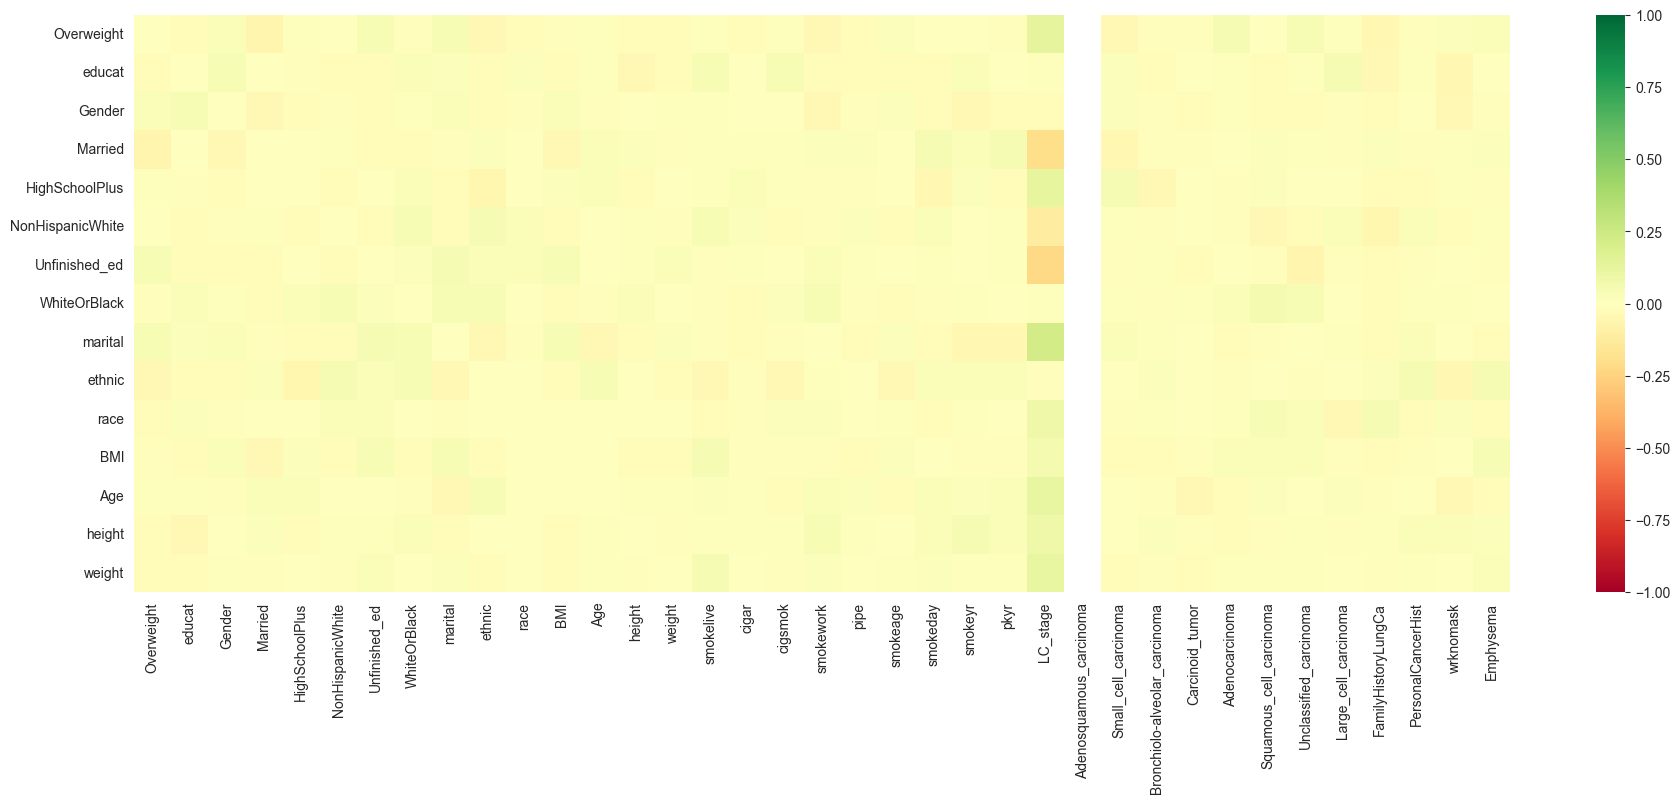

In [25]:
for m in correlations:
    corr_rows = nlst_democols['cat']['demo'] + nlst_democols['num']['demo']
    corr_cols = corr_rows + nlst_democols['cat']['smoke'] + nlst_democols['num']['smoke'] + nlst_democols['cat']['lungcanc'] + nlst_democols['cat']['other']
    # corr_cols = cols_list
    
    display(Markdown(f"### {m}"))
    plt.figure(figsize=(len(corr_cols) * 0.6, len(corr_rows) * 0.5))
    sns.heatmap(correlations[m].loc[corr_rows, corr_cols], cmap='RdYlGn', vmin=-1, vmax=1)
    plt.show()

## What about when Sybil is worse?

In [26]:
sybil_worse_df = pd.read_csv(f"{NLST_PREDS}/sybil_worse.csv")
sybil_worse_df

,col,sym,val
0,wrknomask,=,True
1,FamilyHistoryLungCa,=,True
2,Emphysema,=,True
3,Gender,=,1
4,Married,=,True
5,wrkasbe,=,1
6,wrkfoun,=,1
7,diagadas,=,1
8,diagcopd,=,1
9,diagpneu,=,1


In [27]:
rows = nlst_democols['cat']['demo'] + nlst_democols['num']['demo']
cols = rows + list(set(list(sybil_worse_df['col'])) - set(['NoduleCounts', 'Diameter [mm]'] + rows)) + nlst_democols['cat']['smoke'] + nlst_democols['num']['smoke']
cols

['Overweight',
 'educat',
 'Gender',
 'Married',
 'HighSchoolPlus',
 'NonHispanicWhite',
 'Unfinished_ed',
 'WhiteOrBlack',
 'marital',
 'ethnic',
 'race',
 'BMI',
 'Age',
 'height',
 'weight',
 'wrkasbe',
 'diagadas',
 'diagcopd',
 'wrknomask',
 'wrkfoun',
 'diagpneu',
 'Emphysema',
 'FamilyHistoryLungCa',
 'smokelive',
 'cigar',
 'cigsmok',
 'smokework',
 'pipe',
 'smokeage',
 'smokeday',
 'smokeyr',
 'pkyr']

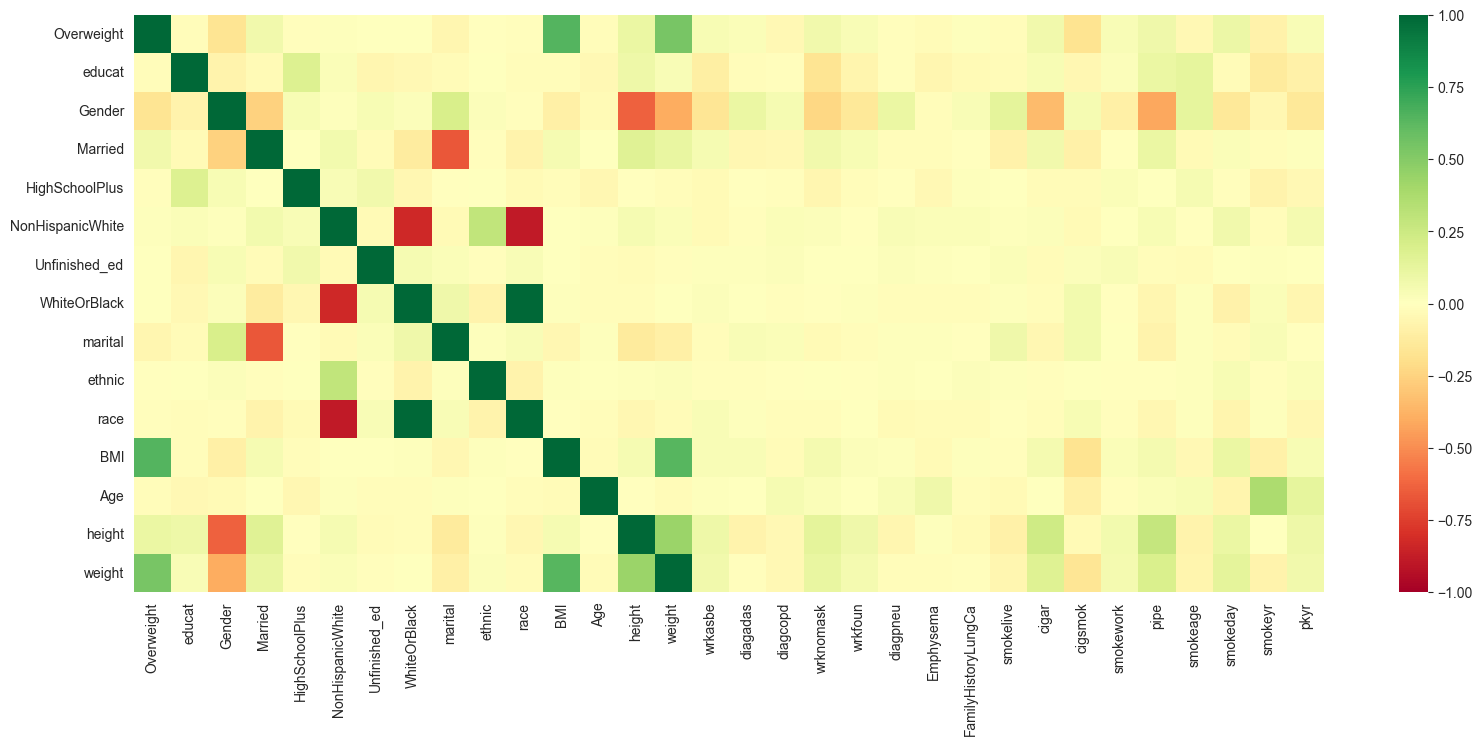

,marital,wrkasbe,diagadas,diagcopd,HighSchoolPlus,wrkfoun,Overweight,WhiteOrBlack,smokeday,pipe,...,NonHispanicWhite,Age,Emphysema,pkyr,FamilyHistoryLungCa,cigar,wrknomask,weight,smokelive,Married
marital,1.000000,-0.022296,0.035441,0.027710,-0.003906,-0.020006,-0.055088,0.078859,-0.026369,-0.077263,...,-0.035578,0.010210,0.012337,-0.007688,-0.000968,-0.054431,-0.031462,-0.101058,0.083967,-0.669615
wrkasbe,-0.022296,1.000000,0.003026,0.008989,-0.033846,0.207960,0.043452,0.017934,0.048709,0.081810,...,-0.036180,0.014064,0.023504,0.055162,0.022625,0.114633,0.333393,0.070850,-0.002208,0.048250
diagadas,0.035441,0.003026,1.000000,0.200026,-0.004373,0.012397,0.023797,0.003778,0.017892,-0.020975,...,-0.010246,0.005194,0.137929,0.005870,0.007449,-0.002225,0.018103,-0.008060,0.029077,-0.049426
diagcopd,0.027710,0.008989,0.200026,1.000000,-0.010915,0.007242,-0.041490,-0.010859,0.029312,-0.007448,...,0.023499,0.048260,0.282179,0.059793,0.012679,-0.001510,0.004093,-0.043114,0.007670,-0.045825
HighSchoolPlus,-0.003906,-0.033846,-0.004373,-0.010915,1.000000,-0.018281,-0.013017,-0.051398,-0.010099,0.006334,...,0.033792,-0.054670,-0.041702,-0.044074,0.011626,-0.027249,-0.062454,-0.020216,0.004299,0.001861
wrkfoun,-0.020006,0.207960,0.012397,0.007242,-0.018281,1.000000,0.034639,0.014485,0.038507,0.079158,...,-0.001720,0.002101,0.041367,0.046950,-0.000401,0.094735,0.329794,0.058107,-0.000231,0.043980
Overweight,-0.055088,0.043452,0.023797,-0.041490,-0.013017,0.034639,1.000000,0.003984,0.096104,0.084928,...,0.012221,-0.016734,-0.029604,0.037293,0.008161,0.077191,0.073187,0.540153,-0.023131,0.078096
WhiteOrBlack,0.078859,0.017934,0.003778,-0.010859,-0.051398,0.014485,0.003984,1.000000,-0.084306,-0.055057,...,-0.835110,-0.016017,-0.017553,-0.058065,-0.016805,-0.021949,-0.005470,0.003777,0.011274,-0.122436
smokeday,-0.026369,0.048709,0.017892,0.029312,-0.010099,0.038507,0.096104,-0.084306,1.000000,0.084635,...,0.077243,-0.063436,0.061993,0.683429,0.025273,0.087557,0.057346,0.140396,0.010831,0.028407
pipe,-0.077263,0.081810,-0.020975,-0.007448,0.006334,0.079158,0.084928,-0.055057,0.084635,1.000000,...,0.043199,0.028623,0.020461,0.073914,-0.003440,0.478894,0.137261,0.190819,-0.044341,0.107649


In [28]:
data.corrmat(sybil_splits['train'], rows, cols)

## Population shift for train and val?

### Sybil

In [29]:
sybil_splits["eval"] = kiran_data

In [30]:
cat_demo_shift = data.combine_diff_dfs(nlst_democols_sybil['cat'], data.diffs_category_prevalence, sybil_splits).query('value != 0')
display(cat_demo_shift.sort_values(by='diff_train_eval', ascending=False).head(20))
cat_demo_shift.sort_values(by='diff_train_eval', ascending=True).head(20)

,category,attribute,value,train_freq,train_norm,dev_freq,dev_norm,test_freq,test_norm,eval_freq,eval_norm,diff_train_dev,diff_train_test,diff_train_eval,diff_dev_test,diff_dev_eval,diff_test_eval
219,lungcanc,LC_stage,NaN,26725.0,94.9041,6506.0,95.1448,5979.0,95.1767,9011.0,88.4906,-0.2407,-0.2726,6.4135,-0.0319,6.6542,6.6861
1,demo,Overweight,True,19898.0,70.6605,4859.0,71.0588,4352.0,69.2773,6963.0,68.3787,-0.3983,1.3832,2.2818,1.7815,2.6801,0.8986
57,smoke,cigar,1.0,5942.0,21.1009,1450.0,21.2050,1376.0,21.9039,1934.0,18.9924,-0.1041,-0.8030,2.1085,-0.6989,2.2126,2.9115
7,demo,educat,6.0,4836.0,17.1733,1177.0,17.2126,1008.0,16.0458,1585.0,15.5652,-0.0393,1.1275,1.6081,1.1668,1.6474,0.4806
12,demo,Gender,1,16572.0,58.8494,4016.0,58.7306,3769.0,59.9968,5834.0,57.2916,0.1188,-1.1474,1.5578,-1.2662,1.4390,2.7052
15,demo,Married,True,19282.0,68.4730,4628.0,67.6806,4295.0,68.3699,6855.0,67.3181,0.7924,0.1031,1.1549,-0.6893,0.3625,1.0518
30,demo,marital,2.0,19282.0,68.4730,4628.0,67.6806,4295.0,68.3699,6855.0,67.3181,0.7924,0.1031,1.1549,-0.6893,0.3625,1.0518
6,demo,educat,5.0,6647.0,23.6044,1521.0,22.2433,1394.0,22.1904,2287.0,22.4590,1.3611,1.4140,1.1454,0.0529,-0.2157,-0.2686
65,smoke,pipe,1.0,6429.0,22.8303,1584.0,23.1647,1508.0,24.0051,2221.0,21.8109,-0.3344,-1.1748,1.0194,-0.8404,1.3538,2.1942
21,demo,Unfinished_ed,True,7912.0,28.0966,1801.0,26.3381,1658.0,26.3929,2805.0,27.5459,1.7585,1.7037,0.5507,-0.0548,-1.2078,-1.1530


,category,attribute,value,train_freq,train_norm,dev_freq,dev_norm,test_freq,test_norm,eval_freq,eval_norm,diff_train_dev,diff_train_test,diff_train_eval,diff_dev_test,diff_dev_eval,diff_test_eval
209,other,Emphysema,1.0,2317.0,8.2280,576.0,8.4235,484.0,7.7046,3697.0,36.3056,-0.1955,0.5234,-28.0776,0.7189,-27.8821,-28.6010
211,lungcanc,LC_stage,110.0,549.0,1.9496,127.0,1.8573,113.0,1.7988,596.0,5.8529,0.0923,0.1508,-3.9033,0.0585,-3.9956,-4.0541
203,other,FamilyHistoryLungCa,True,6232.0,22.1307,1469.0,21.4829,1362.0,21.6810,2622.0,25.7488,0.6478,0.4497,-3.6181,-0.1981,-4.2659,-4.0678
229,lungcanc,Adenocarcinoma,True,558.0,1.9815,82.0,1.1992,107.0,1.7033,539.0,5.2931,0.7823,0.2782,-3.3116,-0.5041,-4.0939,-3.5898
60,smoke,cigsmok,1,13386.0,47.5355,3241.0,47.3969,3026.0,48.1694,5088.0,49.9656,0.1386,-0.6339,-2.4301,-0.7725,-2.5687,-1.7962
122,disease,diagemph,1.0,2317.0,8.2280,576.0,8.4235,484.0,7.7046,1022.0,10.0363,-0.1955,0.5234,-1.8083,0.7189,-1.6128,-2.3317
13,demo,Gender,2,11588.0,41.1506,2822.0,41.2694,2513.0,40.0032,4349.0,42.7084,-0.1188,1.1474,-1.5578,1.2662,-1.4390,-2.7052
4,demo,educat,3.0,6581.0,23.3700,1682.0,24.5978,1571.0,25.0080,2538.0,24.9239,-1.2278,-1.6380,-1.5539,-0.4102,-0.3261,0.0841
143,disease,diagcopd,1.0,1477.0,5.2450,345.0,5.0453,334.0,5.3168,676.0,6.6385,0.1997,-0.0718,-1.3935,-0.2715,-1.5932,-1.3217
225,lungcanc,Bronchiolo-alveolar_carcinoma,True,123.0,0.4368,59.0,0.8628,20.0,0.3184,180.0,1.7677,-0.4260,0.1184,-1.3309,0.5444,-0.9049,-1.4493


In [31]:
num_demo_shift = data.combine_diff_dfs(nlst_democols_sybil['num'], data.diffs_numerical_means, sybil_splits)
display(num_demo_shift.sort_values(by='diff_train_eval', ascending=False).head(20))
num_demo_shift.sort_values(by='diff_train_eval', ascending=True).head(20)

,category,attribute,value,train,dev,test,eval,diff_train_dev,diff_train_test,diff_train_eval,diff_dev_test,diff_dev_eval,diff_test_eval
7,demo,weight,mean,183.4129,183.6606,183.6864,181.8113,-0.2477,-0.2735,1.6016,-0.0258,1.8493,1.8751
1,demo,BMI,mean,27.8681,27.9667,27.8674,27.6277,-0.0986,0.0007,0.2404,0.0993,0.3390,0.2397
0,demo,BMI,50%,27.2592,27.3167,27.0927,27.0197,-0.0575,0.1665,0.2395,0.2240,0.2970,0.0730
9,smoke,smokeage,mean,16.7199,16.7151,16.6479,16.5991,0.0048,0.0720,0.1208,0.0672,0.1160,0.0488
6,demo,weight,50%,180.0000,180.0000,180.0000,180.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
10,smoke,smokeday,50%,25.0000,25.0000,25.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,smoke,smokeage,50%,16.0000,16.0000,16.0000,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,demo,height,50%,68.0000,68.0000,68.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,demo,height,mean,67.8808,67.8172,67.9108,67.8867,0.0636,-0.0300,-0.0059,-0.0936,-0.0695,0.0241
11,smoke,smokeday,mean,28.4474,28.5390,28.9032,28.5740,-0.0916,-0.4558,-0.1266,-0.3642,-0.0350,0.3292


,category,attribute,value,train,dev,test,eval,diff_train_dev,diff_train_test,diff_train_eval,diff_dev_test,diff_dev_eval,diff_test_eval
15,smoke,pkyr,mean,56.1487,56.4101,57.2229,57.9729,-0.2614,-1.0742,-1.8242,-0.8128,-1.5628,-0.7500
3,demo,Age,mean,61.6496,61.6000,61.5807,63.2049,0.0496,0.0689,-1.5553,0.0193,-1.6049,-1.6242
13,smoke,smokeyr,mean,39.9523,39.8867,40.1227,41.0055,0.0656,-0.1704,-1.0532,-0.2360,-1.1188,-0.8828
2,demo,Age,50%,61.0000,61.0000,61.0000,62.0000,0.0000,0.0000,-1.0000,0.0000,-1.0000,-1.0000
12,smoke,smokeyr,50%,40.0000,40.0000,40.0000,41.0000,0.0000,0.0000,-1.0000,0.0000,-1.0000,-1.0000
14,smoke,pkyr,50%,49.0000,48.0000,49.5000,50.0000,1.0000,-0.5000,-1.0000,-1.5000,-2.0000,-0.5000
11,smoke,smokeday,mean,28.4474,28.5390,28.9032,28.5740,-0.0916,-0.4558,-0.1266,-0.3642,-0.0350,0.3292
5,demo,height,mean,67.8808,67.8172,67.9108,67.8867,0.0636,-0.0300,-0.0059,-0.0936,-0.0695,0.0241
4,demo,height,50%,68.0000,68.0000,68.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,smoke,smokeage,50%,16.0000,16.0000,16.0000,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Conclusion: not much demographic shift (1-2% overall not much, really). Besides family history.

### NLST vs. DLCST

In [32]:
dlcst_preds = pd.read_csv(f"{TEAMS_DIR}/dlcst/calibrated_dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
dlcst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            599 non-null    int64  
 1   StudyDate            599 non-null    int64  
 2   SeriesInstanceUID    599 non-null    object 
 3   Age                  599 non-null    int64  
 4   Sex                  599 non-null    int64  
 5   FamilyHistoryLungCa  599 non-null    int64  
 6   Emphysema            599 non-null    int64  
 7   NoduleCountPerScan   599 non-null    int64  
 8   sybil_year1          599 non-null    float64
 9   sybil_year2          599 non-null    float64
 10  sybil_year3          599 non-null    float64
 11  sybil_year4          599 non-null    float64
 12  sybil_year5          599 non-null    float64
 13  sybil_year6          599 non-null    float64
 14  PanCan2b             599 non-null    float64
 15  Ensemble_Kiran       599 non-null    flo

In [33]:
dlcst_preds['Gender'] = dlcst_preds['Sex']
dlcst_preds['NoduleCounts'] = dlcst_preds['NoduleCountPerScan']
dlcst_democols = {'cat': {'all': ['Gender', 'FamilyHistoryLungCa', 'Emphysema']}, 'num': {'all': ['Age', 'NoduleCounts']}}

In [34]:
kiran_data['Emphysema'] = kiran_data['Emphysema'].astype(int)

In [35]:
screening_sets = {
    # "nlst_sybil": sybil_demos,
    "nlst": kiran_data,
    "dlcst": dlcst_preds
}

In [36]:
cat_demo_dlcst = data.combine_diff_dfs(dlcst_democols['cat'], data.diffs_category_prevalence, screening_sets)
display(cat_demo_dlcst.sort_values(by='diff_nlst_dlcst', ascending=False).head(20))
cat_demo_dlcst.sort_values(by='diff_nlst_dlcst', ascending=True).head(20)

,category,attribute,value,nlst_freq,nlst_norm,dlcst_freq,dlcst_norm,diff_nlst_dlcst
4,all,Emphysema,0,6486,63.6944,194,32.3873,31.3071
3,all,FamilyHistoryLungCa,1,2622,25.7488,102,17.0284,8.7204
0,all,Gender,1,5834,57.2916,323,53.9232,3.3684
1,all,Gender,2,4349,42.7084,276,46.0768,-3.3684
2,all,FamilyHistoryLungCa,0,7561,74.2512,497,82.9716,-8.7204
5,all,Emphysema,1,3697,36.3056,405,67.6127,-31.3071


,category,attribute,value,nlst_freq,nlst_norm,dlcst_freq,dlcst_norm,diff_nlst_dlcst
5,all,Emphysema,1,3697,36.3056,405,67.6127,-31.3071
2,all,FamilyHistoryLungCa,0,7561,74.2512,497,82.9716,-8.7204
1,all,Gender,2,4349,42.7084,276,46.0768,-3.3684
0,all,Gender,1,5834,57.2916,323,53.9232,3.3684
3,all,FamilyHistoryLungCa,1,2622,25.7488,102,17.0284,8.7204
4,all,Emphysema,0,6486,63.6944,194,32.3873,31.3071


In [37]:
num_demo_dlcst = data.combine_diff_dfs(dlcst_democols['num'], data.diffs_numerical_means, screening_sets)
display(num_demo_dlcst.sort_values(by='diff_nlst_dlcst', ascending=False).head(20))
num_demo_dlcst.sort_values(by='diff_nlst_dlcst', ascending=True).head(20)

,category,attribute,value,nlst,dlcst,diff_nlst_dlcst
1,all,Age,mean,63.2049,58.3973,4.8076
0,all,Age,50%,62.0000,58.0000,4.0000
2,all,NoduleCounts,mean,1.8835,1.7696,0.1139


,category,attribute,value,nlst,dlcst,diff_nlst_dlcst
2,all,NoduleCounts,mean,1.8835,1.7696,0.1139
0,all,Age,50%,62.0000,58.0000,4.0000
1,all,Age,mean,63.2049,58.3973,4.8076


In [38]:
dlcst_preds['DL_cal'] = dlcst_preds['Ensemble_Kiran_cal']
dlcst_preds['Thijmen_mean_cal'] = dlcst_preds['thijmen_mean_cal']
dlcst_preds

,PatientID,StudyDate,SeriesInstanceUID,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,...,PanCan2b,Ensemble_Kiran,thijmen_mean,label,Ensemble_Kiran_cal,thijmen_mean_cal,Gender,NoduleCounts,DL_cal,Thijmen_mean_cal
0,4,20050124,1.2.840.113704.1.111.4964.1106577805.10,55,2,0,0,9,0.021629,0.038573,...,0.053366,0.082652,0.166209,0,0.119066,0.097887,2,9,0.119066,0.097887
1,35,20051208,1.2.840.113704.1.111.5776.1134059140.11,56,1,1,1,2,0.001170,0.002554,...,0.009543,0.000408,0.003368,0,0.018347,0.006485,1,2,0.018347,0.006485
2,38,20060109,1.2.840.113704.1.111.2004.1136823831.14,62,2,0,1,4,0.001784,0.003870,...,0.006734,0.002702,0.065888,0,0.035409,0.048255,2,4,0.035409,0.048255
3,47,20051214,1.2.840.113704.1.111.8148.1134579622.14,57,1,0,1,1,0.003951,0.015674,...,0.007944,0.084158,0.423341,0,0.119856,0.226322,1,1,0.119856,0.226322
4,56,20051213,1.2.840.113704.1.111.2744.1134487263.11,64,1,0,1,3,0.000000,0.001574,...,0.000899,0.000013,0.005590,0,0.005651,0.008965,1,3,0.005651,0.008965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,4057,20060314,1.2.840.113704.1.111.4796.1142355218.14,69,1,0,1,2,0.168810,0.273494,...,0.380198,0.893933,0.682322,0,0.439657,0.400826,1,2,0.439657,0.400826
595,4063,20060313,1.2.840.113704.1.111.5104.1142267340.10,55,1,0,1,4,0.001965,0.006793,...,0.000000,0.000099,0.103020,0,0.011303,0.067322,1,4,0.011303,0.067322
596,4079,20060328,1.2.840.113704.1.111.1308.1143556124.11,52,2,0,0,1,0.003951,0.011459,...,0.039054,0.070744,0.121373,0,0.112500,0.076349,2,1,0.112500,0.076349
597,4098,20060403,1.2.840.113704.1.111.5848.1144079789.11,54,1,0,1,3,0.117795,0.167839,...,0.134158,0.452513,0.347016,0,0.241085,0.185779,1,3,0.241085,0.185779


In [39]:
dlcst_demo_list = ['Age', 'Gender', 'Emphysema', 'NoduleCounts', 'FamilyHistoryLungCa']
['Age', 'Gender', 'Emphysema', 'NoduleCounts', 'FamilyHistoryLungCa']
dlcst_pred_list = ['DL_cal', 'Thijmen_mean_cal', 'PanCan2b', 'sybil_year1', 'sybil_year2', 'sybil_year3', 'sybil_year4', 'sybil_year5', 'sybil_year6']

### nlst

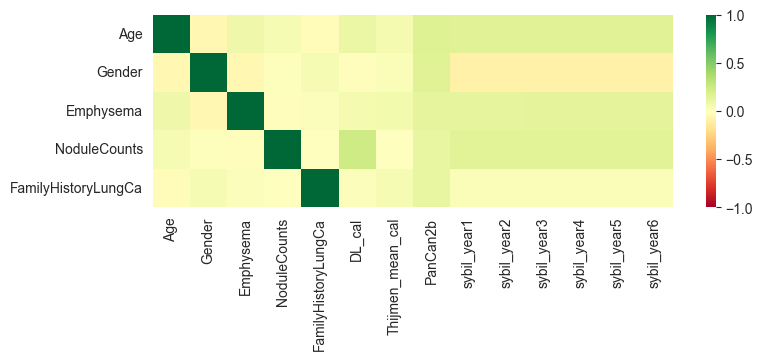

### dlcst

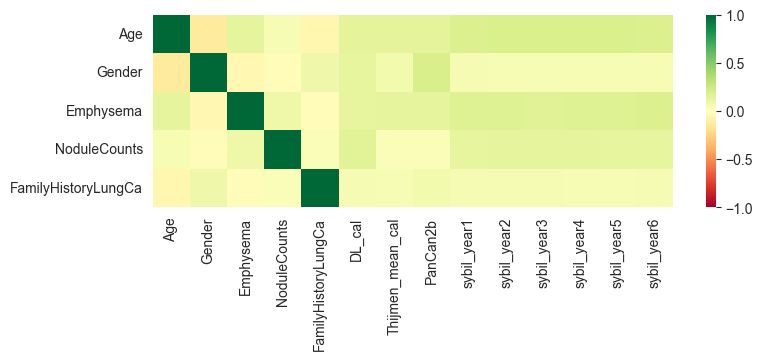

### diff_nlst_dlcst

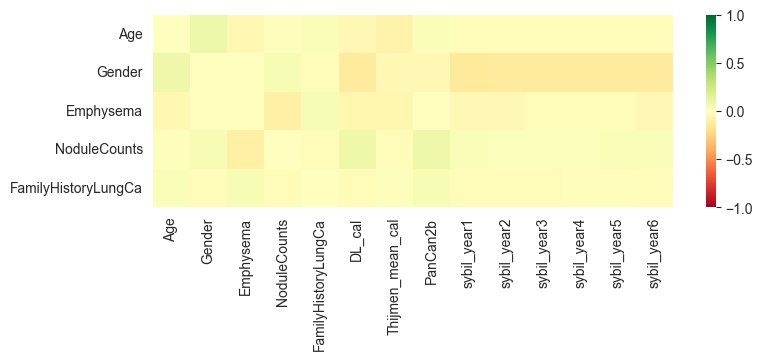

In [40]:
correlations = {m: screening_sets[m][dlcst_demo_list + dlcst_pred_list].corr(method='spearman').round(2) for m in screening_sets}
corr0 = correlations.copy()    
for i, m1 in enumerate(corr0):
    for j, m2 in enumerate(corr0):
        if j > i:
            correlations[f"diff_{m1}_{m2}"] = correlations[f"{m1}"] - correlations[f"{m2}"]

for m in correlations:
    corr_rows = dlcst_demo_list
    corr_cols = corr_rows + dlcst_pred_list
    # corr_cols = cols_list
    
    display(Markdown(f"### {m}"))
    plt.figure(figsize=(len(corr_cols) * 0.6, len(corr_rows) * 0.5))
    sns.heatmap(correlations[m].loc[corr_rows, corr_cols], cmap='RdYlGn', vmin=-1, vmax=1)
    plt.show()

### Different validation sets

In [65]:
all_nodules = pd.read_csv(f"{NLST_PREDS}/nlst_demov4_allmodels_cal.csv")
some_nodules, nlst_democols_nodules, _ = data.prep_nlst_preds(all_nodules, democols=nlst_democols, scanlevel=False, tijmen=True, sybil=False)
print(len(all_nodules), len(some_nodules))

16077 3240


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\nlst\..\utilities\data.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, query_string] = df.eval(query_string)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\nlst\..\utilities\data.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, query_string] = df.eval(query_string)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\nlst\..\utilities\data.py:157: SettingWithCopyWarning: 
A value is trying to be set on a co

In [69]:
all_scans, _, _ = data.prep_nlst_preds(all_nodules, democols=nlst_democols, scanlevel=True, tijmen=False, sybil=True)
some_scans, _, _ = data.prep_nlst_preds(all_nodules, democols=nlst_democols, scanlevel=True, tijmen=True, sybil=True)
print(len(all_scans), len(some_scans))

5911 1172


In [74]:
valsets = {
    "allnodules": all_nodules,
    "somenodules": some_nodules,
    "allscans": all_scans,
    "somescans": some_scans
}

In [75]:
cat_demo_shift = data.combine_diff_dfs(nlst_democols_sybil['cat'], data.diffs_category_prevalence, valsets)
num_demo_shift = data.combine_diff_dfs(nlst_democols_sybil['num'], data.diffs_numerical_means, valsets)

#### Difference between Nodule sets and Scan sets

In [76]:
display(cat_demo_shift.sort_values(by='diff_allnodules_allscans', ascending=False).head(20))
cat_demo_shift.sort_values(by='diff_allnodules_allscans', ascending=True).head(20)

,category,attribute,value,allnodules_freq,allnodules_norm,somenodules_freq,somenodules_norm,allscans_freq,allscans_norm,somescans_freq,somescans_norm,diff_allnodules_somenodules,diff_allnodules_allscans,diff_allnodules_somescans,diff_somenodules_allscans,diff_somenodules_somescans,diff_allscans_somescans
203,lungcanc,LC_stage,NaN,14859,92.4240,2963.0,91.4506,5345.0,90.4246,1047.0,89.3345,0.9734,1.9994,3.0895,1.0260,2.1161,1.0901
193,other,Emphysema,0.0,10385,64.5954,2118.0,65.3704,3755.0,63.5256,733.0,62.5427,-0.7750,1.0698,2.0527,1.8448,2.8277,0.9829
123,disease,diagdiab,1.0,1632,10.1511,360.0,11.1111,545.0,9.2201,126.0,10.7509,-0.9600,0.9310,-0.5998,1.8910,0.3602,-1.5308
42,smoke,cigar,0.0,13031,81.0537,2657.0,82.0062,4738.0,80.1556,931.0,79.4369,-0.9525,0.8981,1.6168,1.8506,2.5693,0.7187
138,disease,diaghype,1.0,5558,34.5711,1051.0,32.4383,1993.0,33.7168,390.0,33.2765,2.1328,0.8543,1.2946,-1.2785,-0.8382,0.4403
71,work,wrkfarm,0.0,14253,88.6546,2841.0,87.6852,5197.0,87.9208,1019.0,86.9454,0.9694,0.7338,1.7092,-0.2356,0.7398,0.9754
1,demo,Overweight,1.0,11015,68.5140,2209.0,68.1790,4012.0,67.8735,801.0,68.3447,0.3350,0.6405,0.1693,0.3055,-0.1657,-0.4712
50,smoke,pipe,0.0,12542,78.0121,2519.0,77.7469,4575.0,77.3981,882.0,75.2560,0.2652,0.6140,2.7561,0.3488,2.4909,2.1421
65,work,wrkfire,0.0,15808,98.3268,3192.0,98.5185,5776.0,97.7161,1153.0,98.3788,-0.1917,0.6107,-0.0520,0.8024,0.1397,-0.6627
24,demo,marital,2.0,10898,67.7863,2182.0,67.3457,3974.0,67.2306,785.0,66.9795,0.4406,0.5557,0.8068,0.1151,0.3662,0.2511


,category,attribute,value,allnodules_freq,allnodules_norm,somenodules_freq,somenodules_norm,allscans_freq,allscans_norm,somescans_freq,somescans_norm,diff_allnodules_somenodules,diff_allnodules_allscans,diff_allnodules_somescans,diff_somenodules_allscans,diff_somenodules_somescans,diff_allscans_somescans
195,lungcanc,LC_stage,110.0,625,3.8875,147.0,4.5370,295.0,4.9907,72.0,6.1433,-0.6495,-1.1032,-2.2558,-0.4537,-1.6063,-1.1526
194,other,Emphysema,1.0,5692,35.4046,1122.0,34.6296,2156.0,36.4744,439.0,37.4573,0.7750,-1.0698,-2.0527,-1.8448,-2.8277,-0.9829
122,disease,diagdiab,0.0,14428,89.7431,2880.0,88.8889,5362.0,90.7122,1046.0,89.2491,0.8542,-0.9691,0.4940,-1.8233,-0.3602,1.4631
137,disease,diaghype,0.0,10489,65.2423,2185.0,67.4383,3909.0,66.1309,778.0,66.3823,-2.1960,-0.8886,-1.1400,1.3074,1.0560,-0.2514
43,smoke,cigar,1.0,2996,18.6353,570.0,17.5926,1148.0,19.4214,235.0,20.0512,1.0427,-0.7861,-1.4159,-1.8288,-2.4586,-0.6298
72,work,wrkfarm,1.0,1820,11.3205,399.0,12.3148,713.0,12.0623,153.0,13.0546,-0.9943,-0.7418,-1.7341,0.2525,-0.7398,-0.9923
0,demo,Overweight,0.0,5062,31.4860,1031.0,31.8210,1899.0,32.1265,371.0,31.6553,-0.3350,-0.6405,-0.1693,-0.3055,0.1657,0.4712
51,smoke,pipe,1.0,3438,21.3846,702.0,21.6667,1301.0,22.0098,283.0,24.1468,-0.2821,-0.6252,-2.7622,-0.3431,-2.4801,-2.1370
27,demo,marital,5.0,2957,18.3927,574.0,17.7160,1123.0,18.9985,202.0,17.2355,0.6767,-0.6058,1.1572,-1.2825,0.4805,1.7630
66,work,wrkfire,1.0,268,1.6670,48.0,1.4815,134.0,2.2670,19.0,1.6212,0.1855,-0.6000,0.0458,-0.7855,-0.1397,0.6458


In [77]:
display(num_demo_shift.sort_values(by='diff_allnodules_allscans', ascending=False).head(20))
num_demo_shift.sort_values(by='diff_allnodules_allscans', ascending=True).head(20)

,category,attribute,value,allnodules,somenodules,allscans,somescans,diff_allnodules_somenodules,diff_allnodules_allscans,diff_allnodules_somescans,diff_somenodules_allscans,diff_somenodules_somescans,diff_allscans_somescans
2,demo,Age,50%,63.0000,63.0000,62.0000,63.0000,0.0000,1.0000,0.0000,1.0000,0.0000,-1.0000
7,demo,weight,mean,182.4158,182.1708,181.9230,182.8019,0.2450,0.4928,-0.3861,0.2478,-0.6311,-0.8789
0,demo,BMI,50%,27.0435,27.1219,26.8702,27.0435,-0.0784,0.1733,0.0000,0.2517,0.0784,-0.1733
1,demo,BMI,mean,27.6610,27.6556,27.5553,27.5442,0.0054,0.1057,0.1168,0.1003,0.1114,0.0111
3,demo,Age,mean,63.2881,63.5269,63.1839,63.2927,-0.2388,0.1042,-0.0046,0.3430,0.2342,-0.1088
9,smoke,smokeage,mean,16.5716,16.5861,16.4926,16.4241,-0.0145,0.0790,0.1475,0.0935,0.1620,0.0685
6,demo,weight,50%,180.0000,178.0000,180.0000,180.0000,2.0000,0.0000,0.0000,-2.0000,-2.0000,0.0000
4,demo,height,50%,68.0000,68.0000,68.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
14,smoke,pkyr,50%,51.0000,51.0000,51.0000,52.0000,0.0000,0.0000,-1.0000,0.0000,-1.0000,-1.0000
8,smoke,smokeage,50%,16.0000,16.0000,16.0000,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


,category,attribute,value,allnodules,somenodules,allscans,somescans,diff_allnodules_somenodules,diff_allnodules_allscans,diff_allnodules_somescans,diff_somenodules_allscans,diff_somenodules_somescans,diff_allscans_somescans
15,smoke,pkyr,mean,58.1140,57.6895,58.3153,58.1227,0.4245,-0.2013,-0.0087,-0.6258,-0.4332,0.1926
11,smoke,smokeday,mean,28.5803,28.6019,28.6383,28.7065,-0.0216,-0.0580,-0.1262,-0.0364,-0.1046,-0.0682
13,smoke,smokeyr,mean,41.1264,41.0907,41.1685,41.2329,0.0357,-0.0421,-0.1065,-0.0778,-0.1422,-0.0644
5,demo,height,mean,67.9641,67.9253,67.9798,68.1314,0.0388,-0.0157,-0.1673,-0.0545,-0.2061,-0.1516
8,smoke,smokeage,50%,16.0000,16.0000,16.0000,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,demo,height,50%,68.0000,68.0000,68.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,demo,weight,50%,180.0000,178.0000,180.0000,180.0000,2.0000,0.0000,0.0000,-2.0000,-2.0000,0.0000
12,smoke,smokeyr,50%,41.0000,41.0000,41.0000,41.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
14,smoke,pkyr,50%,51.0000,51.0000,51.0000,52.0000,0.0000,0.0000,-1.0000,0.0000,-1.0000,-1.0000
10,smoke,smokeday,50%,25.0000,25.0000,25.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


#### Diff between sets for Tijmen's combined model vs. the rest

In [78]:
display(cat_demo_shift.sort_values(by='diff_allscans_somescans', ascending=False).head(20))
cat_demo_shift.sort_values(by='diff_allscans_somescans', ascending=True).head(20)

,category,attribute,value,allnodules_freq,allnodules_norm,somenodules_freq,somenodules_norm,allscans_freq,allscans_norm,somescans_freq,somescans_norm,diff_allnodules_somenodules,diff_allnodules_allscans,diff_allnodules_somescans,diff_somenodules_allscans,diff_somenodules_somescans,diff_allscans_somescans
62,work,wrkasbe,0.0,15277,95.0239,2980.0,91.9753,5610.0,94.9078,1082.0,92.3208,3.0486,0.1161,2.7031,-2.9325,-0.3455,2.5870
50,smoke,pipe,0.0,12542,78.0121,2519.0,77.7469,4575.0,77.3981,882.0,75.2560,0.2652,0.6140,2.7561,0.3488,2.4909,2.1421
5,demo,educat,4.0,2307,14.3497,443.0,13.6728,852.0,14.4138,144.0,12.2867,0.6769,-0.0641,2.0630,-0.7410,1.3861,2.1271
45,smoke,cigsmok,0.0,7911,49.2069,1592.0,49.1358,2930.0,49.5686,560.0,47.7816,0.0711,-0.3617,1.4253,-0.4328,1.3542,1.7870
27,demo,marital,5.0,2957,18.3927,574.0,17.7160,1123.0,18.9985,202.0,17.2355,0.6767,-0.6058,1.1572,-1.2825,0.4805,1.7630
122,disease,diagdiab,0.0,14428,89.7431,2880.0,88.8889,5362.0,90.7122,1046.0,89.2491,0.8542,-0.9691,0.4940,-1.8233,-0.3602,1.4631
6,demo,educat,5.0,3539,22.0128,680.0,20.9877,1301.0,22.0098,244.0,20.8191,1.0251,0.0030,1.1937,-1.0221,0.1686,1.1907
216,lungcanc,Unclassified_carcinoma,0.0,15953,99.2287,3194.0,98.5802,5840.0,98.7988,1145.0,97.6962,0.6485,0.4299,1.5325,-0.2186,0.8840,1.1026
107,disease,diagemph,0.0,14283,88.8412,2908.0,89.7531,5265.0,89.0712,1031.0,87.9693,-0.9119,-0.2300,0.8719,0.6819,1.7838,1.1019
203,lungcanc,LC_stage,NaN,14859,92.4240,2963.0,91.4506,5345.0,90.4246,1047.0,89.3345,0.9734,1.9994,3.0895,1.0260,2.1161,1.0901


,category,attribute,value,allnodules_freq,allnodules_norm,somenodules_freq,somenodules_norm,allscans_freq,allscans_norm,somescans_freq,somescans_norm,diff_allnodules_somenodules,diff_allnodules_allscans,diff_allnodules_somescans,diff_somenodules_allscans,diff_somenodules_somescans,diff_allscans_somescans
63,work,wrkasbe,1.0,789,4.9076,259.0,7.9938,300.0,5.0753,90.0,7.6792,-3.0862,-0.1677,-2.7716,2.9185,0.3146,-2.6039
51,smoke,pipe,1.0,3438,21.3846,702.0,21.6667,1301.0,22.0098,283.0,24.1468,-0.2821,-0.6252,-2.7622,-0.3431,-2.4801,-2.1370
46,smoke,cigsmok,1.0,8166,50.7931,1648.0,50.8642,2981.0,50.4314,612.0,52.2184,-0.0711,0.3617,-1.4253,0.4328,-1.3542,-1.7870
25,demo,marital,3.0,1327,8.2540,315.0,9.7222,507.0,8.5772,120.0,10.2389,-1.4682,-0.3232,-1.9849,1.1450,-0.5167,-1.6617
123,disease,diagdiab,1.0,1632,10.1511,360.0,11.1111,545.0,9.2201,126.0,10.7509,-0.9600,0.9310,-0.5998,1.8910,0.3602,-1.5308
4,demo,educat,3.0,4077,25.3592,801.0,24.7222,1479.0,25.0211,307.0,26.1945,0.6370,0.3381,-0.8353,-0.2989,-1.4723,-1.1734
195,lungcanc,LC_stage,110.0,625,3.8875,147.0,4.5370,295.0,4.9907,72.0,6.1433,-0.6495,-1.1032,-2.2558,-0.4537,-1.6063,-1.1526
30,demo,ethnic,2.0,15779,98.1464,3200.0,98.7654,5779.0,97.7669,1159.0,98.8908,-0.6190,0.3795,-0.7444,0.9985,-0.1254,-1.1239
217,lungcanc,Unclassified_carcinoma,1.0,124,0.7713,46.0,1.4198,71.0,1.2012,27.0,2.3038,-0.6485,-0.4299,-1.5325,0.2186,-0.8840,-1.1026
17,demo,NonHispanicWhite,1.0,14818,92.1689,2994.0,92.4074,5430.0,91.8626,1089.0,92.9181,-0.2385,0.3063,-0.7492,0.5448,-0.5107,-1.0555


In [79]:
display(num_demo_shift.sort_values(by='diff_allscans_somescans', ascending=False).head(20))
num_demo_shift.sort_values(by='diff_allscans_somescans', ascending=True).head(20)

,category,attribute,value,allnodules,somenodules,allscans,somescans,diff_allnodules_somenodules,diff_allnodules_allscans,diff_allnodules_somescans,diff_somenodules_allscans,diff_somenodules_somescans,diff_allscans_somescans
15,smoke,pkyr,mean,58.1140,57.6895,58.3153,58.1227,0.4245,-0.2013,-0.0087,-0.6258,-0.4332,0.1926
9,smoke,smokeage,mean,16.5716,16.5861,16.4926,16.4241,-0.0145,0.0790,0.1475,0.0935,0.1620,0.0685
1,demo,BMI,mean,27.6610,27.6556,27.5553,27.5442,0.0054,0.1057,0.1168,0.1003,0.1114,0.0111
4,demo,height,50%,68.0000,68.0000,68.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,smoke,smokeage,50%,16.0000,16.0000,16.0000,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
10,smoke,smokeday,50%,25.0000,25.0000,25.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,demo,weight,50%,180.0000,178.0000,180.0000,180.0000,2.0000,0.0000,0.0000,-2.0000,-2.0000,0.0000
12,smoke,smokeyr,50%,41.0000,41.0000,41.0000,41.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
13,smoke,smokeyr,mean,41.1264,41.0907,41.1685,41.2329,0.0357,-0.0421,-0.1065,-0.0778,-0.1422,-0.0644
11,smoke,smokeday,mean,28.5803,28.6019,28.6383,28.7065,-0.0216,-0.0580,-0.1262,-0.0364,-0.1046,-0.0682


,category,attribute,value,allnodules,somenodules,allscans,somescans,diff_allnodules_somenodules,diff_allnodules_allscans,diff_allnodules_somescans,diff_somenodules_allscans,diff_somenodules_somescans,diff_allscans_somescans
2,demo,Age,50%,63.0000,63.0000,62.0000,63.0000,0.0000,1.0000,0.0000,1.0000,0.0000,-1.0000
14,smoke,pkyr,50%,51.0000,51.0000,51.0000,52.0000,0.0000,0.0000,-1.0000,0.0000,-1.0000,-1.0000
7,demo,weight,mean,182.4158,182.1708,181.9230,182.8019,0.2450,0.4928,-0.3861,0.2478,-0.6311,-0.8789
0,demo,BMI,50%,27.0435,27.1219,26.8702,27.0435,-0.0784,0.1733,0.0000,0.2517,0.0784,-0.1733
5,demo,height,mean,67.9641,67.9253,67.9798,68.1314,0.0388,-0.0157,-0.1673,-0.0545,-0.2061,-0.1516
3,demo,Age,mean,63.2881,63.5269,63.1839,63.2927,-0.2388,0.1042,-0.0046,0.3430,0.2342,-0.1088
11,smoke,smokeday,mean,28.5803,28.6019,28.6383,28.7065,-0.0216,-0.0580,-0.1262,-0.0364,-0.1046,-0.0682
13,smoke,smokeyr,mean,41.1264,41.0907,41.1685,41.2329,0.0357,-0.0421,-0.1065,-0.0778,-0.1422,-0.0644
12,smoke,smokeyr,50%,41.0000,41.0000,41.0000,41.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,demo,weight,50%,180.0000,178.0000,180.0000,180.0000,2.0000,0.0000,0.0000,-2.0000,-2.0000,0.0000


## What about men vs. women?

### Training sets

In [41]:
gender_train_sets = {
    "M":sybil_splits['train'].query('Gender == 1'),
    "F":sybil_splits['train'].query('Gender == 2'),
}

In [42]:
cat_demo_gender = data.combine_diff_dfs(nlst_democols_sybil['cat'], data.diffs_category_prevalence, gender_train_sets, include_stat=True).query('value != 0')
display(cat_demo_gender.sort_values(by='diff_M_F', ascending=False))
cat_demo_gender.sort_values(by='diff_M_F', ascending=True)

C:\Users\shaur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\proportion.py:1769: RuntimeWarning: divide by zero encountered in scalar divide
  odds_ratio = p1 / (1 - p1) / p2 * (1 - p2)


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_M_F,stat_M_F,p_M_F
60,smoke,pipe,1.0,6186.0,37.3280,243.0,2.0970,35.2310,88.386383,0.0
52,smoke,cigar,1.0,5465.0,32.9773,477.0,4.1163,28.8610,70.533064,0.0
14,demo,Married,1.0,12987.0,78.3671,6295.0,54.3234,24.0437,42.742945,0.0
29,demo,marital,2.0,12987.0,78.3671,6295.0,54.3234,24.0437,42.742945,0.0
201,other,wrknomask,1.0,5486.0,33.1040,1495.0,12.9013,20.2027,42.070788,0.0
...,...,...,...,...,...,...,...,...,...,...
167,canchist,canccerv,1.0,NaN,NaN,393.0,3.3914,NaN,NaN,NaN
170,canchist,cancstom,1.0,6.0,0.0362,NaN,NaN,NaN,NaN,NaN
176,canchist,canctran,1.0,NaN,NaN,7.0,0.0604,NaN,NaN,NaN
182,canchist,canclary,1.0,13.0,0.0784,NaN,NaN,NaN,NaN,NaN


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_M_F,stat_M_F,p_M_F
32,demo,marital,5.0,2148.0,12.9616,3057.0,26.3807,-13.4191,-27.641877,3.494461e-168
30,demo,marital,3.0,566.0,3.4154,1489.0,12.8495,-9.4341,-27.634809,4.249472e-168
49,smoke,smokelive,1.0,13873.0,83.7135,10752.0,92.7856,-9.0721,-24.243129,7.813098e-130
111,disease,diagpneu,1.0,3095.0,18.6761,3183.0,27.4681,-8.7920,-17.125074,9.648654e-66
150,disease,diagchro,1.0,1132.0,6.8308,1618.0,13.9627,-7.1319,-18.921346,7.608662e-80
...,...,...,...,...,...,...,...,...,...,...
167,canchist,canccerv,1.0,NaN,NaN,393.0,3.3914,NaN,NaN,NaN
170,canchist,cancstom,1.0,6.0,0.0362,NaN,NaN,NaN,NaN,NaN
176,canchist,canctran,1.0,NaN,NaN,7.0,0.0604,NaN,NaN,NaN
182,canchist,canclary,1.0,13.0,0.0784,NaN,NaN,NaN,NaN,NaN


In [43]:
display(cat_demo_gender.sort_values(by='diff_M_F', ascending=False).query('category == "lungcanc"'))
cat_demo_gender.sort_values(by='diff_M_F', ascending=True).query('category == "lungcanc"')

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_M_F,stat_M_F,p_M_F
225,lungcanc,Squamous_cell_carcinoma,1.0,250.0,1.5086,106.0,0.9147,0.5939,4.583207,0.000005
211,lungcanc,LC_stage,400.0,254.0,1.5327,130.0,1.1219,0.4108,3.006118,0.002646
207,lungcanc,LC_stage,210.0,70.0,0.4224,28.0,0.2416,0.1808,2.660040,0.007813
213,lungcanc,LC_stage,NaN,15737.0,94.9614,10988.0,94.8222,0.1392,0.521339,0.602131
217,lungcanc,Small_cell_carcinoma,1.0,119.0,0.7181,80.0,0.6904,0.0277,0.274115,0.783996
208,lungcanc,LC_stage,220.0,29.0,0.1750,18.0,0.1553,0.0197,0.401954,0.687718
215,lungcanc,Adenosquamous_carcinoma,1.0,14.0,0.0845,10.0,0.0863,-0.0018,-0.051304,0.959084
212,lungcanc,LC_stage,900.0,3.0,0.0181,3.0,0.0259,-0.0078,-0.426947,0.669418
227,lungcanc,Unclassified_carcinoma,1.0,92.0,0.5552,66.0,0.5696,-0.0144,-0.158859,0.873780
209,lungcanc,LC_stage,310.0,102.0,0.6155,74.0,0.6386,-0.0231,-0.241224,0.809382


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_M_F,stat_M_F,p_M_F
205,lungcanc,LC_stage,110.0,284.0,1.7137,265.0,2.2868,-0.5731,-3.339789,0.000838
219,lungcanc,Bronchiolo-alveolar_carcinoma,1.0,47.0,0.2836,76.0,0.6559,-0.3723,-4.348065,0.000014
223,lungcanc,Adenocarcinoma,1.0,305.0,1.8405,253.0,2.1833,-0.3428,-2.001829,0.045303
210,lungcanc,LC_stage,320.0,32.0,0.1931,32.0,0.2761,-0.0830,-1.395978,0.162721
206,lungcanc,LC_stage,120.0,61.0,0.3681,50.0,0.4315,-0.0634,-0.823843,0.410029
229,lungcanc,Large_cell_carcinoma,1.0,18.0,0.1086,17.0,0.1467,-0.0381,-0.869463,0.384594
221,lungcanc,Carcinoid_tumor,1.0,1.0,0.0060,4.0,0.0345,-0.0285,-1.558146,0.119199
209,lungcanc,LC_stage,310.0,102.0,0.6155,74.0,0.6386,-0.0231,-0.241224,0.809382
227,lungcanc,Unclassified_carcinoma,1.0,92.0,0.5552,66.0,0.5696,-0.0144,-0.158859,0.873780
212,lungcanc,LC_stage,900.0,3.0,0.0181,3.0,0.0259,-0.0078,-0.426947,0.669418


In [44]:
num_demo_gender = data.combine_diff_dfs(nlst_democols_sybil['num'], data.diffs_numerical_means, gender_train_sets, include_stat=True)
display(num_demo_gender.sort_values(by='diff_M_F', ascending=False).head(20))
num_demo_gender.sort_values(by='diff_M_F', ascending=True).head(20)

,category,attribute,value,M,F,diff_M_F,stat_M_F,p_M_F
6,demo,weight,50%,195.0000,157.0000,38.0000,85.449791,0.000000e+00
7,demo,weight,mean,198.2521,162.1246,36.1275,85.449791,0.000000e+00
10,smoke,smokeday,50%,30.0000,20.0000,10.0000,26.078155,3.715016e-148
15,smoke,pkyr,mean,59.6811,51.0970,8.5841,30.427542,4.140730e-200
14,smoke,pkyr,50%,52.0000,45.0000,7.0000,30.427542,4.140730e-200
4,demo,height,50%,70.0000,64.0000,6.0000,181.182113,0.000000e+00
5,demo,height,mean,70.2740,64.4574,5.8166,181.182113,0.000000e+00
11,smoke,smokeday,mean,29.8936,26.3792,3.5144,26.078155,3.715016e-148
2,demo,Age,50%,61.0000,60.0000,1.0000,7.108716,1.199168e-12
0,demo,BMI,50%,27.5461,26.5684,0.9777,12.938133,3.526578e-38


,category,attribute,value,M,F,diff_M_F,stat_M_F,p_M_F
9,smoke,smokeage,mean,16.2727,17.3593,-1.0866,-25.186671,1.915804e-138
8,smoke,smokeage,50%,16.0000,17.0000,-1.0000,-25.186671,1.915804e-138
12,smoke,smokeyr,50%,40.0000,40.0000,0.0000,10.415331,2.346940e-25
3,demo,Age,mean,61.8288,61.3933,0.4355,7.108716,1.199168e-12
1,demo,BMI,mean,28.1879,27.4096,0.7783,12.938133,3.526578e-38
13,smoke,smokeyr,mean,40.3346,39.4056,0.9290,10.415331,2.346940e-25
0,demo,BMI,50%,27.5461,26.5684,0.9777,12.938133,3.526578e-38
2,demo,Age,50%,61.0000,60.0000,1.0000,7.108716,1.199168e-12
11,smoke,smokeday,mean,29.8936,26.3792,3.5144,26.078155,3.715016e-148
5,demo,height,mean,70.2740,64.4574,5.8166,181.182113,0.000000e+00


In [45]:
cat_demo_gender[cat_demo_gender['attribute'].isin(set(sybil_worse_df['col']))].query('value == 1').sort_values(by='diff_M_F', ascending=True)

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_M_F,stat_M_F,p_M_F
111,disease,diagpneu,1.0,3095.0,18.6761,3183.0,27.4681,-8.7920,-17.125074,9.648654e-66
135,disease,diagadas,1.0,658.0,3.9706,1072.0,9.2509,-5.2803,-17.090989,1.732114e-65
197,other,FamilyHistoryLungCa,1.0,3476.0,20.9751,2756.0,23.7832,-2.8081,-5.545105,2.937770e-08
138,disease,diagcopd,1.0,722.0,4.3567,755.0,6.5154,-2.1587,-7.743676,9.658305e-15
203,other,Emphysema,1.0,1444.0,8.7135,873.0,7.5337,1.1798,3.588256,3.328970e-04
66,work,wrkfoun,1.0,1139.0,6.8730,94.0,0.8112,6.0618,28.397602,2.164798e-177
72,work,wrkasbe,1.0,1256.0,7.5790,65.0,0.5609,7.0181,32.344239,1.671830e-229
201,other,wrknomask,1.0,5486.0,33.1040,1495.0,12.9013,20.2027,42.070788,0.000000e+00
14,demo,Married,1.0,12987.0,78.3671,6295.0,54.3234,24.0437,42.742945,0.000000e+00
11,demo,Gender,1.0,16572.0,100.0000,NaN,NaN,NaN,NaN,NaN


### Evaluation sets (Kiran data)

In [46]:
gender_eval_sets = {
    "M":kiran_data.query('Gender == 1'),
    "F":kiran_data.query('Gender == 2'),
}

In [47]:
cat_gender_eval = data.combine_diff_dfs(nlst_democols_val['cat'], data.diffs_category_prevalence, gender_eval_sets).query('value != 0')
display(cat_gender_eval.sort_values(by='diff_M_F', ascending=False).head(40))
cat_gender_eval.sort_values(by='diff_M_F', ascending=True).head(40)

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_M_F
51,smoke,pipe,1.0,2133.0,36.5615,88.0,2.0235,34.5380
43,smoke,cigar,1.0,1795.0,30.7679,139.0,3.1961,27.5718
24,demo,marital,2.0,4531.0,77.6654,2324.0,53.4376,24.2278
13,demo,Married,True,4531.0,77.6654,2324.0,53.4376,24.2278
210,other,wrknomask,True,2005.0,34.3675,577.0,13.2674,21.1001
1,demo,Overweight,True,4318.0,74.0144,2645.0,60.8186,13.1958
72,work,wrkfarm,1.0,907.0,15.5468,262.0,6.0244,9.5224
202,nodule,Solid,True,4074.0,69.8320,2626.0,60.3817,9.4503
120,disease,diaghear,1.0,983.0,16.8495,349.0,8.0248,8.8247
81,work,wrkweld,1.0,552.0,9.4618,44.0,1.0117,8.4501


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_M_F
27,demo,marital,5.0,797.0,13.6613,1107.0,25.4541,-11.7928
25,demo,marital,3.0,205.0,3.5139,659.0,15.1529,-11.6390
102,disease,diagpneu,1.0,1086.0,18.6150,1270.0,29.2021,-10.5871
40,smoke,smokelive,1.0,4887.0,83.7676,4078.0,93.7687,-10.0011
188,nodule,GroundGlassOpacity,True,1406.0,24.1001,1453.0,33.4100,-9.3099
141,disease,diagchro,1.0,393.0,6.7364,671.0,15.4288,-8.6924
126,disease,diagadas,1.0,205.0,3.5139,461.0,10.6001,-7.0862
4,demo,educat,3.0,1284.0,22.0089,1254.0,28.8342,-6.8253
208,other,PersonalCancerHist,True,120.0,2.0569,357.0,8.2088,-6.1519
206,other,FamilyHistoryLungCa,True,1384.0,23.7230,1238.0,28.4663,-4.7433


In [48]:
display(cat_gender_eval.query('category == "nodule"').sort_values(by='diff_M_F', ascending=False).head(40))
cat_gender_eval.query('category == "nodule"').sort_values(by='diff_M_F', ascending=True).head(40)

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_M_F
202,nodule,Solid,True,4074.0,69.8320,2626.0,60.3817,9.4503
192,nodule,Perifissural,True,564.0,9.6675,261.0,6.0014,3.6661
196,nodule,Calcified,True,5.0,0.0857,3.0,0.0690,0.0167
198,nodule,Spiculation,True,10.0,0.1714,10.0,0.2299,-0.0585
194,nodule,NonSolid,True,66.0,1.1313,58.0,1.3336,-0.2023
200,nodule,PartSolid,True,101.0,1.7312,139.0,3.1961,-1.4649
204,nodule,SemiSolid,True,666.0,11.4158,640.0,14.7160,-3.3002
190,nodule,NoduleInUpperLung,True,2919.0,50.0343,2343.0,53.8745,-3.8402
188,nodule,GroundGlassOpacity,True,1406.0,24.1001,1453.0,33.4100,-9.3099


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_M_F
188,nodule,GroundGlassOpacity,True,1406.0,24.1001,1453.0,33.4100,-9.3099
190,nodule,NoduleInUpperLung,True,2919.0,50.0343,2343.0,53.8745,-3.8402
204,nodule,SemiSolid,True,666.0,11.4158,640.0,14.7160,-3.3002
200,nodule,PartSolid,True,101.0,1.7312,139.0,3.1961,-1.4649
194,nodule,NonSolid,True,66.0,1.1313,58.0,1.3336,-0.2023
198,nodule,Spiculation,True,10.0,0.1714,10.0,0.2299,-0.0585
196,nodule,Calcified,True,5.0,0.0857,3.0,0.0690,0.0167
192,nodule,Perifissural,True,564.0,9.6675,261.0,6.0014,3.6661
202,nodule,Solid,True,4074.0,69.8320,2626.0,60.3817,9.4503


In [49]:
display(cat_gender_eval.query('attribute == "LC_stage"').sort_values(by='diff_M_F', ascending=False).head(40))
cat_gender_eval.query('attribute == "LC_stage"').sort_values(by='diff_M_F', ascending=True).head(40)

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_M_F
221,lungcanc,LC_stage,400.0,125.0,2.1426,44.0,1.0117,1.1309
217,lungcanc,LC_stage,210.0,65.0,1.1142,19.0,0.4369,0.6773
220,lungcanc,LC_stage,320.0,20.0,0.3428,11.0,0.2529,0.0899
219,lungcanc,LC_stage,310.0,78.0,1.3370,58.0,1.3336,0.0034
222,lungcanc,LC_stage,900.0,1.0,0.0171,3.0,0.0690,-0.0519
216,lungcanc,LC_stage,120.0,61.0,1.0456,51.0,1.1727,-0.1271
218,lungcanc,LC_stage,220.0,18.0,0.3085,22.0,0.5059,-0.1974
223,lungcanc,LC_stage,NaN,5154.0,88.3442,3857.0,88.6871,-0.3429
215,lungcanc,LC_stage,110.0,312.0,5.3480,284.0,6.5302,-1.1822


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_M_F
215,lungcanc,LC_stage,110.0,312.0,5.3480,284.0,6.5302,-1.1822
223,lungcanc,LC_stage,NaN,5154.0,88.3442,3857.0,88.6871,-0.3429
218,lungcanc,LC_stage,220.0,18.0,0.3085,22.0,0.5059,-0.1974
216,lungcanc,LC_stage,120.0,61.0,1.0456,51.0,1.1727,-0.1271
222,lungcanc,LC_stage,900.0,1.0,0.0171,3.0,0.0690,-0.0519
219,lungcanc,LC_stage,310.0,78.0,1.3370,58.0,1.3336,0.0034
220,lungcanc,LC_stage,320.0,20.0,0.3428,11.0,0.2529,0.0899
217,lungcanc,LC_stage,210.0,65.0,1.1142,19.0,0.4369,0.6773
221,lungcanc,LC_stage,400.0,125.0,2.1426,44.0,1.0117,1.1309


In [50]:
num_gender_eval = data.combine_diff_dfs(nlst_democols_val['num'], data.diffs_numerical_means, gender_eval_sets)
display(num_gender_eval.sort_values(by='diff_M_F', ascending=False).head(20))
num_gender_eval.sort_values(by='diff_M_F', ascending=True).head(20)

,category,attribute,value,M,F,diff_M_F
6,demo,weight,50%,193.0000,157.0000,36.0000
7,demo,weight,mean,196.7960,161.7294,35.0666
20,other,SliceCount,mean,174.9587,163.9939,10.9648
10,smoke,smokeday,50%,30.0000,20.0000,10.0000
19,other,SliceCount,50%,165.0000,155.0000,10.0000
15,smoke,pkyr,mean,62.0469,52.5078,9.5391
14,smoke,pkyr,50%,55.0000,46.0000,9.0000
4,demo,height,50%,70.0000,64.0000,6.0000
5,demo,height,mean,70.4206,64.4917,5.9289
11,smoke,smokeday,mean,30.2072,26.3831,3.8241


,category,attribute,value,M,F,diff_M_F
9,smoke,smokeage,mean,16.1409,17.2138,-1.0729
8,smoke,smokeage,50%,16.0000,17.0000,-1.0000
16,other,NoduleCounts,mean,1.8819,1.8857,-0.0038
17,other,Diameter_mm,50%,7.3000,7.2000,0.1000
18,other,Diameter_mm,mean,9.4266,8.9452,0.4814
1,demo,BMI,mean,27.8551,27.3230,0.5321
3,demo,Age,mean,63.4344,62.8972,0.5372
0,demo,BMI,50%,27.2592,26.5180,0.7412
2,demo,Age,50%,63.0000,62.0000,1.0000
12,smoke,smokeyr,50%,41.0000,40.0000,1.0000


In [51]:
cat_gender_eval[cat_gender_eval['attribute'].isin(set(sybil_worse_df['col']))].query('value == 1').sort_values(by='diff_M_F', ascending=True)

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_M_F
102,disease,diagpneu,1.0,1086.0,18.6150,1270.0,29.2021,-10.5871
126,disease,diagadas,1.0,205.0,3.5139,461.0,10.6001,-7.0862
206,other,FamilyHistoryLungCa,True,1384.0,23.7230,1238.0,28.4663,-4.7433
129,disease,diagcopd,1.0,336.0,5.7593,340.0,7.8179,-2.0586
212,other,Emphysema,1,2242.0,38.4299,1455.0,33.4560,4.9739
57,work,wrkfoun,1.0,412.0,7.0621,29.0,0.6668,6.3953
63,work,wrkasbe,1.0,453.0,7.7648,28.0,0.6438,7.1210
210,other,wrknomask,True,2005.0,34.3675,577.0,13.2674,21.1001
13,demo,Married,True,4531.0,77.6654,2324.0,53.4376,24.2278
10,demo,Gender,1,5834.0,100.0000,NaN,NaN,NaN


## What about BMI?

### Sybil training set

In [52]:
sybil_train_over = sybil_splits['train'].query('Overweight == 1')
sybil_train_normal = sybil_splits['train'].query('Overweight == 0')

overweight_train_sets = {
    "over":sybil_train_over,
    "normal":sybil_train_normal,
}

In [53]:
cat_demo_overweight = data.combine_diff_dfs(nlst_democols_sybil['cat'], data.diffs_category_prevalence, overweight_train_sets).query('value != 0')
display(cat_demo_overweight.sort_values(by='diff_over_normal', ascending=False).head(40))
cat_demo_overweight.sort_values(by='diff_over_normal', ascending=True).head(40)

,category,attribute,value,over_freq,over_norm,normal_freq,normal_norm,diff_over_normal
11,demo,Gender,1.0,12764.0,64.1472,3808.0,46.0905,18.0567
147,disease,diaghype,1.0,7824.0,39.3205,2032.0,24.5945,14.7260
132,disease,diagdiab,1.0,2441.0,12.2676,340.0,4.1152,8.1524
14,demo,Married,1.0,14090.0,70.8111,5192.0,62.8419,7.9692
29,demo,marital,2.0,14090.0,70.8111,5192.0,62.8419,7.9692
60,smoke,pipe,1.0,4998.0,25.1181,1431.0,17.3203,7.7978
201,other,wrknomask,1.0,5338.0,26.8268,1643.0,19.8862,6.9406
52,smoke,cigar,1.0,4601.0,23.1229,1341.0,16.2309,6.8920
129,disease,diaghear,1.0,2893.0,14.5391,761.0,9.2108,5.3283
81,work,wrkfarm,1.0,2405.0,12.0866,713.0,8.6299,3.4567


,category,attribute,value,over_freq,over_norm,normal_freq,normal_norm,diff_over_normal
55,smoke,cigsmok,1.0,8339.0,41.9087,5047.0,61.0869,-19.1782
12,demo,Gender,2.0,7134.0,35.8528,4454.0,53.9095,-18.0567
32,demo,marital,5.0,3347.0,16.8208,1858.0,22.4885,-5.6677
138,disease,diagcopd,1.0,925.0,4.6487,552.0,6.6812,-2.0325
117,disease,diagemph,1.0,1533.0,7.7043,784.0,9.4892,-1.7849
203,other,Emphysema,1.0,1533.0,7.7043,784.0,9.4892,-1.7849
49,smoke,smokelive,1.0,17307.0,86.9786,7318.0,88.5742,-1.5956
8,demo,educat,7.0,2732.0,13.7300,1244.0,15.0569,-1.3269
28,demo,marital,1.0,835.0,4.1964,439.0,5.3135,-1.1171
223,lungcanc,Adenocarcinoma,1.0,333.0,1.6735,225.0,2.7233,-1.0498


In [54]:
display(cat_demo_overweight.sort_values(by='diff_over_normal', ascending=False).query('category == "lungcanc"'))
cat_demo_overweight.sort_values(by='diff_over_normal', ascending=True).query('category == "lungcanc"')

,category,attribute,value,over_freq,over_norm,normal_freq,normal_norm,diff_over_normal
213,lungcanc,LC_stage,NaN,18989.0,95.4317,7736.0,93.6335,1.7982
215,lungcanc,Adenosquamous_carcinoma,1.0,20.0,0.1005,4.0,0.0484,0.0521
210,lungcanc,LC_stage,320.0,46.0,0.2312,18.0,0.2179,0.0133
221,lungcanc,Carcinoid_tumor,1.0,4.0,0.0201,1.0,0.0121,0.0080
212,lungcanc,LC_stage,900.0,3.0,0.0151,3.0,0.0363,-0.0212
208,lungcanc,LC_stage,220.0,27.0,0.1357,20.0,0.2421,-0.1064
207,lungcanc,LC_stage,210.0,63.0,0.3166,35.0,0.4236,-0.1070
229,lungcanc,Large_cell_carcinoma,1.0,18.0,0.0905,17.0,0.2058,-0.1153
209,lungcanc,LC_stage,310.0,117.0,0.5880,59.0,0.7141,-0.1261
206,lungcanc,LC_stage,120.0,70.0,0.3518,41.0,0.4962,-0.1444


,category,attribute,value,over_freq,over_norm,normal_freq,normal_norm,diff_over_normal
223,lungcanc,Adenocarcinoma,1.0,333.0,1.6735,225.0,2.7233,-1.0498
205,lungcanc,LC_stage,110.0,342.0,1.7188,207.0,2.5054,-0.7866
211,lungcanc,LC_stage,400.0,241.0,1.2112,143.0,1.7308,-0.5196
227,lungcanc,Unclassified_carcinoma,1.0,98.0,0.4925,60.0,0.7262,-0.2337
219,lungcanc,Bronchiolo-alveolar_carcinoma,1.0,75.0,0.3769,48.0,0.5810,-0.2041
217,lungcanc,Small_cell_carcinoma,1.0,131.0,0.6584,68.0,0.8230,-0.1646
225,lungcanc,Squamous_cell_carcinoma,1.0,243.0,1.2212,113.0,1.3677,-0.1465
206,lungcanc,LC_stage,120.0,70.0,0.3518,41.0,0.4962,-0.1444
209,lungcanc,LC_stage,310.0,117.0,0.5880,59.0,0.7141,-0.1261
229,lungcanc,Large_cell_carcinoma,1.0,18.0,0.0905,17.0,0.2058,-0.1153


In [55]:
num_demo_overweight = data.combine_diff_dfs(nlst_democols_sybil['num'], data.diffs_numerical_means, overweight_train_sets)
display(num_demo_overweight.sort_values(by='diff_over_normal', ascending=False).head(20))
num_demo_overweight.sort_values(by='diff_over_normal', ascending=True).head(20)

,category,attribute,value,over,normal,diff_over_normal
7,demo,weight,mean,198.7192,146.2254,52.4938
6,demo,weight,50%,195.0000,145.0000,50.0000
10,smoke,smokeday,50%,30.0000,20.0000,10.0000
1,demo,BMI,mean,30.0004,22.6737,7.3267
0,demo,BMI,50%,28.9410,23.0260,5.9150
15,smoke,pkyr,mean,56.9631,54.1872,2.7759
11,smoke,smokeday,mean,29.1976,26.6405,2.5571
14,smoke,pkyr,50%,49.5000,47.5000,2.0000
5,demo,height,mean,68.1749,67.1694,1.0055
4,demo,height,50%,68.0000,67.0000,1.0000


,category,attribute,value,over,normal,diff_over_normal
13,smoke,smokeyr,mean,39.4865,41.0742,-1.5877
8,smoke,smokeage,50%,16.0000,17.0000,-1.0000
12,smoke,smokeyr,50%,40.0000,41.0000,-1.0000
9,smoke,smokeage,mean,16.6196,16.9614,-0.3418
3,demo,Age,mean,61.5771,61.8241,-0.2470
2,demo,Age,50%,61.0000,61.0000,0.0000
4,demo,height,50%,68.0000,67.0000,1.0000
5,demo,height,mean,68.1749,67.1694,1.0055
14,smoke,pkyr,50%,49.5000,47.5000,2.0000
11,smoke,smokeday,mean,29.1976,26.6405,2.5571


### Evaluation set (Kiran Data)

In [56]:
kiran_data_over = kiran_data.query('Overweight == 1')
kiran_data_normal = kiran_data.query('Overweight == 0')

overweight_eval_sets = {
    "over":kiran_data_over,
    "normal":kiran_data_normal,
}

In [57]:
cat_eval_overweight = data.combine_diff_dfs(nlst_democols_val['cat'], data.diffs_category_prevalence, overweight_eval_sets).query('value != 0')
display(cat_eval_overweight.sort_values(by='diff_over_normal', ascending=False).head(40))
cat_eval_overweight.sort_values(by='diff_over_normal', ascending=True).head(40)

,category,attribute,value,over_freq,over_norm,normal_freq,normal_norm,diff_over_normal
10,demo,Gender,1,4318.0,62.0135,1516.0,47.0807,14.9328
138,disease,diaghype,1.0,2749.0,39.4801,813.0,25.2484,14.2317
24,demo,marital,2.0,4878.0,70.0560,1977.0,61.3975,8.6585
13,demo,Married,True,4878.0,70.0560,1977.0,61.3975,8.6585
123,disease,diagdiab,1.0,867.0,12.4515,124.0,3.8509,8.6006
51,smoke,pipe,1.0,1679.0,24.1132,542.0,16.8323,7.2809
43,smoke,cigar,1.0,1473.0,21.1547,461.0,14.3168,6.8379
120,disease,diaghear,1.0,1051.0,15.0941,281.0,8.7267,6.3674
210,other,wrknomask,True,1835.0,26.3536,747.0,23.1988,3.1548
192,nodule,Perifissural,True,625.0,8.9760,200.0,6.2112,2.7648


,category,attribute,value,over_freq,over_norm,normal_freq,normal_norm,diff_over_normal
46,smoke,cigsmok,1,3084.0,44.2913,2004.0,62.2360,-17.9447
212,other,Emphysema,1,2195.0,31.5238,1502.0,46.6460,-15.1222
11,demo,Gender,2,2645.0,37.9865,1704.0,52.9193,-14.9328
27,demo,marital,5.0,1176.0,16.8893,728.0,22.6087,-5.7194
190,nodule,NoduleInUpperLung,True,3499.0,50.2513,1763.0,54.7516,-4.5003
102,disease,diagpneu,1.0,1522.0,21.8584,834.0,25.9006,-4.0422
108,disease,diagemph,1.0,629.0,9.0335,393.0,12.2050,-3.1715
129,disease,diagcopd,1.0,397.0,5.7016,279.0,8.6646,-2.9630
204,nodule,SemiSolid,True,831.0,11.9345,475.0,14.7516,-2.8171
214,other,label,1,768.0,11.0297,431.0,13.3851,-2.3554


In [58]:
display(cat_eval_overweight.sort_values(by='diff_over_normal', ascending=False).query('category == "nodule"'))
cat_eval_overweight.sort_values(by='diff_over_normal', ascending=True).query('category == "nodule"')

,category,attribute,value,over_freq,over_norm,normal_freq,normal_norm,diff_over_normal
192,nodule,Perifissural,True,625.0,8.9760,200.0,6.2112,2.7648
188,nodule,GroundGlassOpacity,True,1989.0,28.5653,870.0,27.0186,1.5467
194,nodule,NonSolid,True,89.0,1.2782,35.0,1.0870,0.1912
196,nodule,Calcified,True,3.0,0.0431,5.0,0.1553,-0.1122
202,nodule,Solid,True,4577.0,65.7332,2123.0,65.9317,-0.1985
198,nodule,Spiculation,True,7.0,0.1005,13.0,0.4037,-0.3032
200,nodule,PartSolid,True,138.0,1.9819,102.0,3.1677,-1.1858
204,nodule,SemiSolid,True,831.0,11.9345,475.0,14.7516,-2.8171
190,nodule,NoduleInUpperLung,True,3499.0,50.2513,1763.0,54.7516,-4.5003


,category,attribute,value,over_freq,over_norm,normal_freq,normal_norm,diff_over_normal
190,nodule,NoduleInUpperLung,True,3499.0,50.2513,1763.0,54.7516,-4.5003
204,nodule,SemiSolid,True,831.0,11.9345,475.0,14.7516,-2.8171
200,nodule,PartSolid,True,138.0,1.9819,102.0,3.1677,-1.1858
198,nodule,Spiculation,True,7.0,0.1005,13.0,0.4037,-0.3032
202,nodule,Solid,True,4577.0,65.7332,2123.0,65.9317,-0.1985
196,nodule,Calcified,True,3.0,0.0431,5.0,0.1553,-0.1122
194,nodule,NonSolid,True,89.0,1.2782,35.0,1.0870,0.1912
188,nodule,GroundGlassOpacity,True,1989.0,28.5653,870.0,27.0186,1.5467
192,nodule,Perifissural,True,625.0,8.9760,200.0,6.2112,2.7648


In [59]:
num_eval_overweight = data.combine_diff_dfs(nlst_democols_val['num'], data.diffs_numerical_means, overweight_eval_sets)
display(num_eval_overweight.sort_values(by='diff_over_normal', ascending=False).head(20))
num_eval_overweight.sort_values(by='diff_over_normal', ascending=True).head(20)

,category,attribute,value,over,normal,diff_over_normal
7,demo,weight,mean,198.3737,145.7502,52.6235
6,demo,weight,50%,195.0000,145.0000,50.0000
10,smoke,smokeday,50%,28.0000,20.0000,8.0000
1,demo,BMI,mean,29.9508,22.5585,7.3923
0,demo,BMI,50%,28.9719,22.9619,6.0100
11,smoke,smokeday,mean,29.2309,27.1534,2.0775
15,smoke,pkyr,mean,58.4821,56.8718,1.6103
4,demo,height,50%,68.0000,67.0000,1.0000
14,smoke,pkyr,50%,51.0000,50.0000,1.0000
5,demo,height,mean,68.1811,67.2473,0.9338


,category,attribute,value,over,normal,diff_over_normal
20,other,SliceCount,mean,168.8502,173.6024,-4.7522
19,other,SliceCount,50%,160.0000,163.0000,-3.0000
12,smoke,smokeyr,50%,40.0000,42.0000,-2.0000
13,smoke,smokeyr,mean,40.4237,42.2637,-1.8400
2,demo,Age,50%,62.0000,63.0000,-1.0000
18,other,Diameter_mm,mean,9.0120,9.6729,-0.6609
3,demo,Age,mean,63.0955,63.4416,-0.3461
9,smoke,smokeage,mean,16.4968,16.8205,-0.3237
17,other,Diameter_mm,50%,7.2000,7.4000,-0.2000
16,other,NoduleCounts,mean,1.8827,1.8854,-0.0027


## What about race?

### Kiran data

In [60]:
kiran_data_white = kiran_data.query('race == 1')
kiran_data_black = kiran_data.query('race == 2')

race_kiran_sets = {
    "white":kiran_data_white,
    "black":kiran_data_black,
}

In [61]:
cat_race_kiran = data.combine_diff_dfs(nlst_democols['cat'], data.diffs_category_prevalence, race_kiran_sets, include_stat=True).query('value != 0')
display(cat_race_kiran.sort_values(by='diff_white_black', ascending=False).head(40))
cat_race_kiran.sort_values(by='diff_white_black', ascending=True).head(40)

C:\Users\shaur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\proportion.py:1769: RuntimeWarning: divide by zero encountered in scalar divide
  odds_ratio = p1 / (1 - p1) / p2 * (1 - p2)
C:\Users\shaur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\proportion.py:1769: RuntimeWarning: divide by zero encountered in scalar divide
  odds_ratio = p1 / (1 - p1) / p2 * (1 - p2)


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_white_black,stat_white_black,p_white_black
13,demo,Married,True,6464.0,68.3226,127.0,37.5740,30.7486,11.484578,1.577044e-30
23,demo,marital,2.0,6464.0,68.3226,127.0,37.5740,30.7486,11.484578,1.577044e-30
45,smoke,pipe,1.0,2147.0,22.6932,27.0,7.9882,14.7050,9.572134,1.047217e-21
10,demo,Gender,1,5432.0,57.4146,149.0,44.0828,13.3318,4.851527,1.225147e-06
62,work,wrkfarm,1.0,1125.0,11.8909,9.0,2.6627,9.2282,9.851018,6.785323e-23
4,demo,educat,3.0,2410.0,25.4730,61.0,18.0473,7.4257,3.471116,5.182993e-04
37,smoke,cigar,1.0,1838.0,19.4271,41.0,12.1302,7.2969,4.005365,6.192181e-05
5,demo,educat,4.0,1345.0,14.2163,28.0,8.2840,5.9323,3.847914,1.191280e-04
239,scanner,ManufacturersModelName,Mx8000,599.0,6.3313,3.0,0.8876,5.4437,9.579139,9.785698e-22
7,demo,educat,6.0,1493.0,15.7806,35.0,10.3550,5.4256,3.193234,1.406887e-03


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_white_black,stat_white_black,p_white_black
121,disease,diaghype,1.0,3203.0,33.8548,195.0,57.6923,-23.8375,-8.728667,2.576914e-18
40,smoke,cigsmok,1,4665.0,49.3077,232.0,68.6391,-19.3314,-7.506103,6.091341e-14
19,demo,Unfinished_ed,True,2547.0,26.9210,152.0,44.9704,-18.0494,-6.577752,4.776144e-11
26,demo,marital,5.0,1715.0,18.1270,114.0,33.7278,-15.6008,-5.995891,2.023732e-09
11,demo,Gender,2,4029.0,42.5854,189.0,55.9172,-13.3318,-4.851527,1.225147e-06
223,scanner,Manufacturer,SIEMENS,3528.0,37.2899,166.0,49.1124,-11.8225,-4.276870,1.895395e-05
106,disease,diagdiab,1.0,831.0,8.7834,67.0,19.8225,-11.0391,-5.045557,4.522031e-07
243,scanner,ManufacturersModelName,Sensation 16,1196.0,12.6414,77.0,22.7811,-10.1397,-4.395599,1.104677e-05
3,demo,educat,2.0,454.0,4.7986,48.0,14.2012,-9.4026,-4.919388,8.681501e-07
6,demo,educat,5.0,2093.0,22.1224,104.0,30.7692,-8.6468,-3.395645,6.846721e-04


In [62]:
display(cat_race_kiran.query('category == "nodule"').sort_values(by='diff_white_black', ascending=False).head(40))
cat_race_kiran.query('category == "nodule"').sort_values(by='diff_white_black', ascending=True).head(40)

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_white_black,stat_white_black,p_white_black
175,nodule,Perifissural,True,779.0,8.2338,18.0,5.3254,2.9084,2.319991,0.020341
185,nodule,Solid,True,6275.0,66.3249,218.0,64.4970,1.8279,0.690341,0.489980
183,nodule,PartSolid,True,226.0,2.3888,5.0,1.4793,0.9095,1.347050,0.177964
177,nodule,NonSolid,True,120.0,1.2684,3.0,0.8876,0.3808,0.728127,0.466536
173,nodule,NoduleInUpperLung,True,4879.0,51.5696,179.0,52.9586,-1.3890,-0.502695,0.615179
171,nodule,GroundGlassOpacity,True,2632.0,27.8195,99.0,29.2899,-1.4704,-0.584011,0.559213
187,nodule,SemiSolid,True,1194.0,12.6202,50.0,14.7929,-2.1727,-1.107909,0.267901
179,nodule,Calcified,True,8.0,0.0846,NaN,NaN,NaN,NaN,NaN
181,nodule,Spiculation,True,19.0,0.2008,NaN,NaN,NaN,NaN,NaN


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_white_black,stat_white_black,p_white_black
187,nodule,SemiSolid,True,1194.0,12.6202,50.0,14.7929,-2.1727,-1.107909,0.267901
171,nodule,GroundGlassOpacity,True,2632.0,27.8195,99.0,29.2899,-1.4704,-0.584011,0.559213
173,nodule,NoduleInUpperLung,True,4879.0,51.5696,179.0,52.9586,-1.3890,-0.502695,0.615179
177,nodule,NonSolid,True,120.0,1.2684,3.0,0.8876,0.3808,0.728127,0.466536
183,nodule,PartSolid,True,226.0,2.3888,5.0,1.4793,0.9095,1.347050,0.177964
185,nodule,Solid,True,6275.0,66.3249,218.0,64.4970,1.8279,0.690341,0.489980
175,nodule,Perifissural,True,779.0,8.2338,18.0,5.3254,2.9084,2.319991,0.020341
179,nodule,Calcified,True,8.0,0.0846,NaN,NaN,NaN,NaN,NaN
181,nodule,Spiculation,True,19.0,0.2008,NaN,NaN,NaN,NaN,NaN


In [63]:
display(cat_race_kiran.query('attribute == "LC_stage"').sort_values(by='diff_white_black', ascending=False).head(40))
cat_race_kiran.query('attribute == "LC_stage"').sort_values(by='diff_white_black', ascending=True).head(40)

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_white_black,stat_white_black,p_white_black
204,lungcanc,LC_stage,NaN,8387.0,88.6481,282.0,83.4320,5.2161,2.546442,0.010883
197,lungcanc,LC_stage,120.0,106.0,1.1204,4.0,1.1834,-0.0630,-0.105410,0.916051
198,lungcanc,LC_stage,210.0,77.0,0.8139,3.0,0.8876,-0.0737,-0.142165,0.886950
199,lungcanc,LC_stage,220.0,36.0,0.3805,2.0,0.5917,-0.2112,-0.500559,0.616682
202,lungcanc,LC_stage,400.0,157.0,1.6594,7.0,2.0710,-0.4116,-0.523833,0.600395
200,lungcanc,LC_stage,310.0,119.0,1.2578,6.0,1.7751,-0.5173,-0.711313,0.476890
201,lungcanc,LC_stage,320.0,26.0,0.2748,5.0,1.4793,-1.2045,-1.828154,0.067526
196,lungcanc,LC_stage,110.0,549.0,5.8028,29.0,8.5799,-2.7771,-1.800737,0.071744
203,lungcanc,LC_stage,900.0,4.0,0.0423,NaN,NaN,NaN,NaN,NaN


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_white_black,stat_white_black,p_white_black
196,lungcanc,LC_stage,110.0,549.0,5.8028,29.0,8.5799,-2.7771,-1.800737,0.071744
201,lungcanc,LC_stage,320.0,26.0,0.2748,5.0,1.4793,-1.2045,-1.828154,0.067526
200,lungcanc,LC_stage,310.0,119.0,1.2578,6.0,1.7751,-0.5173,-0.711313,0.476890
202,lungcanc,LC_stage,400.0,157.0,1.6594,7.0,2.0710,-0.4116,-0.523833,0.600395
199,lungcanc,LC_stage,220.0,36.0,0.3805,2.0,0.5917,-0.2112,-0.500559,0.616682
198,lungcanc,LC_stage,210.0,77.0,0.8139,3.0,0.8876,-0.0737,-0.142165,0.886950
197,lungcanc,LC_stage,120.0,106.0,1.1204,4.0,1.1834,-0.0630,-0.105410,0.916051
204,lungcanc,LC_stage,NaN,8387.0,88.6481,282.0,83.4320,5.2161,2.546442,0.010883
203,lungcanc,LC_stage,900.0,4.0,0.0423,NaN,NaN,NaN,NaN,NaN


In [64]:
num_race_kiran = data.combine_diff_dfs(nlst_democols_val['num'], data.diffs_numerical_means, race_kiran_sets, include_stat=True)
display(num_race_kiran.sort_values(by='diff_white_black', ascending=False).head(20))
num_race_kiran.sort_values(by='diff_white_black', ascending=True).head(20)

,category,attribute,value,white,black,diff_white_black,stat_white_black,p_white_black
15,smoke,pkyr,mean,58.2982,49.4726,8.8256,6.577601,5.025140e-11
14,smoke,pkyr,50%,51.0000,44.0000,7.0000,6.577601,5.025140e-11
11,smoke,smokeday,mean,28.7498,23.3994,5.3504,8.534595,1.615239e-17
10,smoke,smokeday,50%,25.0000,20.0000,5.0000,8.534595,1.615239e-17
6,demo,weight,50%,180.0000,178.0000,2.0000,0.562112,5.740526e-01
7,demo,weight,mean,182.0639,180.8542,1.2097,0.562112,5.740526e-01
2,demo,Age,50%,63.0000,62.0000,1.0000,2.191158,2.846383e-02
4,demo,height,50%,68.0000,67.0000,1.0000,3.412383,6.465818e-04
5,demo,height,mean,67.9504,67.2047,0.7457,3.412383,6.465818e-04
3,demo,Age,mean,63.2459,62.6095,0.6364,2.191158,2.846383e-02


,category,attribute,value,white,black,diff_white_black,stat_white_black,p_white_black
20,other,SliceCount,mean,170.4577,180.2394,-9.7817,-2.632583,8.496641e-03
13,smoke,smokeyr,mean,40.9904,42.3077,-1.3173,-3.247603,1.167731e-03
12,smoke,smokeyr,50%,41.0000,42.0000,-1.0000,-3.247603,1.167731e-03
8,smoke,smokeage,50%,16.0000,17.0000,-1.0000,-1.577698,1.146672e-01
1,demo,BMI,mean,27.6099,28.3226,-0.7127,-2.577897,9.954865e-03
18,other,Diameter_mm,mean,9.2075,9.8432,-0.6357,-1.900713,5.736896e-02
17,other,Diameter_mm,50%,7.2000,7.6500,-0.4500,-1.900713,5.736896e-02
9,smoke,smokeage,mean,16.5805,16.8876,-0.3071,-1.577698,1.146672e-01
19,other,SliceCount,50%,161.0000,161.0000,0.0000,-2.632583,8.496641e-03
16,other,NoduleCounts,mean,1.8937,1.7929,0.1008,1.442862,1.490914e-01
